In [1]:
# import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web


#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets

               "Total Base": "BOGMBASE",
                "Total Assets":"WALCL",
               # Liabilities
#                "Total Liabilities" : "WLTLECL",
               # Interest Rates
#                "CPI":"CPIAUCSL",
               "PCEPI":"PCEPILFE",
               "Currency in Circulation": "WCURCIR",
                "Reserves at Fed":"RESBALNS",
#                "MB": "BOGMBASE",

#                "VIX": "VIXCLS",
               }

rate_codes = {"Effective Federal Funds Rate (%)": "DFF",
#               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
#                "Federal Funds Upper Target":"DFEDTARU",
#                "Federal Funds Lower Target":"DFEDTARL",
#                "Interest on Reserves (%)": "IOER",
#                 "5 Year Forward Rate": "T5YIFR",
               "Unemployment Rate": "UNRATE",
              "$U_N$": "NROU",
            "$\pi_{1e}$" : "EXPINF1YR"
             }


inflation_target = 2

# Select start and end dates
start = datetime.datetime(1982, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [2]:
rate_keys = list(rate_codes.keys())
diffs = ["Diff"]#, "2Diffs"], "3Diffs"]

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days

if "data_gathered" not in locals():
    orig_data = gather_data(data_codes, start, 
          end = end, freq = freq)
#     data["Currency in Circulation"] = data["Total Base"].div(data["Reserves at Fed"])
    rate_data = gather_data(rate_codes, start, 
          end = end, freq = freq)
    rate_data["$U_N$"] = rate_data["$U_N$"].interpolate(method='linear')
    # transform bil to mil
#     data["Currency in Circulation"] = data["Total Base"].sub(data["Reserves at Fed"])
    #     data.fillna(0, inplace=True)
    orig_data = orig_data.iloc[year:]
    log_data = np.log(orig_data)
    log_diff_data = log_data.diff(year)
    log_diff_data[rate_keys] = rate_data[rate_keys]
    
    # calculate monthly rates as well. This data will be used for ADF and KPSS tests (lags = 12)
    monthly_log_diff_data = log_data.diff()
    monthly_log_diff_data[rate_keys] = rate_data[rate_keys]
    
    data = log_diff_data
    monthly_data = monthly_log_diff_data
    data_gathered = True


In [3]:
for df in [data,monthly_data]:
    
#     df["Currency in Circulation / Total Base"] = df["Currency in Circulation"].div(df["Total Base"].mul(1000))
    df["Inflation Loss"]= orig_data["PCEPI"].pct_change(year).mul(100).sub(inflation_target)
#     df["Inflation Loss"]= df["$\pi_{1e}$"].sub(inflation_target)
    df["Unemployment Loss"]= df["Unemployment Rate"].sub(df["$U_N$"])#unemployment_target)
    df["Inflation Loss Sq"]= df["Inflation Loss"].pow(2)
    df["Inflation Loss Sq"][df["Inflation Loss"] < 0] = df["Inflation Loss Sq"][df["Inflation Loss"] < 0] .mul(-1)
    df["Unemployment Loss Sq"]= df["Unemployment Loss"].pow(2)
    df["Unemployment Loss Sq"][df["Unemployment Loss"] < 0] = df["Unemployment Loss Sq"][df["Unemployment Loss"] < 0].mul(-1)
    df["Loss Function"] = df["Inflation Loss Sq"].sub(df["Unemployment Loss Sq"])

In [4]:
data={"Rates":data,
     "Diff": data.diff(year),}
#      "2Diff": data.diff(year).diff(year),}
#       "3Diff":data.diff(year).diff(year).diff(year)}
monthly_data={"Rates":monthly_data,
     "Diff": monthly_data.diff(),}
#      "2Diff": monthly_data.diff().diff()}
#     "3Diff":monthly_data.diff().diff().diff()}
diffs = list(data.keys())
for key, val in data.items():
    data[key]["Date"] = val.index.astype(str)

## If data is already downloaded, you can just load it from parquet. If you need to restart kernel, consider commenting out previous two cells

In [5]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# data.to_parquet("FedDAGData.parquet.gzip", compression = "gzip",
#                     engine = "pyarrow")
# data.to_csv("FedDAGData.csv")
# data["Diff"].describe().T

In [6]:
# import pandas as pd
# data = pd.read_parquet("FedDAGData.parquet.gzip")

In [7]:
# data = monthly_data

In [8]:
rename_dct = {"Total Assets":"A",
             "Total Base":"B",
              "Currency in Circulation":"C",
                "Effective Federal Funds Rate (%)":"FFR",
              "Loss Function":"LF"}
test_vars = list(rename_dct.values())
for diff, val in data.items():
    val = val.rename(columns = rename_dct).loc["1986":"2020-02"]
    table=val.describe().loc[["count", "mean", "min", "max"]].T
    table["SD"] = val.dropna().std()
    for key in table.index:
        table["SD"].loc[key] = val[key].dropna().std()
    table["count"].loc["A"] = len(val["A"].loc["2006-02":"2020-02"].dropna())
    table["mean"].loc["A"] = val["A"].loc["2006-02":"2020-02"].dropna().mean()
    table["min"].loc["A"] = val["A"].loc["2006-02":"2020-02"].dropna().min()    
    table["max"].loc["A"] = val["A"].loc["2006-02":"2020-02"].dropna().max()
    table["SD"].loc["A"] = val["A"].loc["2006-02":"2020-02"].dropna().std()
    table.loc[test_vars].round(3).to_csv(diff + "SummaryStats.csv")

C:\Users\JLCat\AppData\Local\Temp\ipykernel_19260\1486101429.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  table["SD"] = val.dropna().std()
C:\Users\JLCat\AppData\Local\Temp\ipykernel_19260\1486101429.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  table["SD"] = val.dropna().std()


In [9]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from arch.unitroot import ADF, KPSS
import copy
import pingouin
from scipy.stats import pearsonr
from datlib.ts_tests import *
from statsmodels.tsa.adfvalues import *
import warnings
warnings.simplefilter("ignore")
import statsmodels
from statsmodels.tools.validation import (
    array_like,
    bool_like,
    dict_like,
    float_like,
    int_like,
    string_like,
)

from statsmodels.tools.sm_exceptions import (
    CollinearityWarning,
    InfeasibleTestError,
    InterpolationWarning,
    MissingDataError,
)




### For the unit root tests, we use monthly data since data frequency must match lag frequency for these tests. Since the annually differenced data covers data of 12 months, we simply test if there is a unit root 12 months out. We infer from the tests using 12 monthly lags that we can use the annual lags and annual rates for our DAG estimates.

['A', 'B', 'C', 'FFR', 'LF']


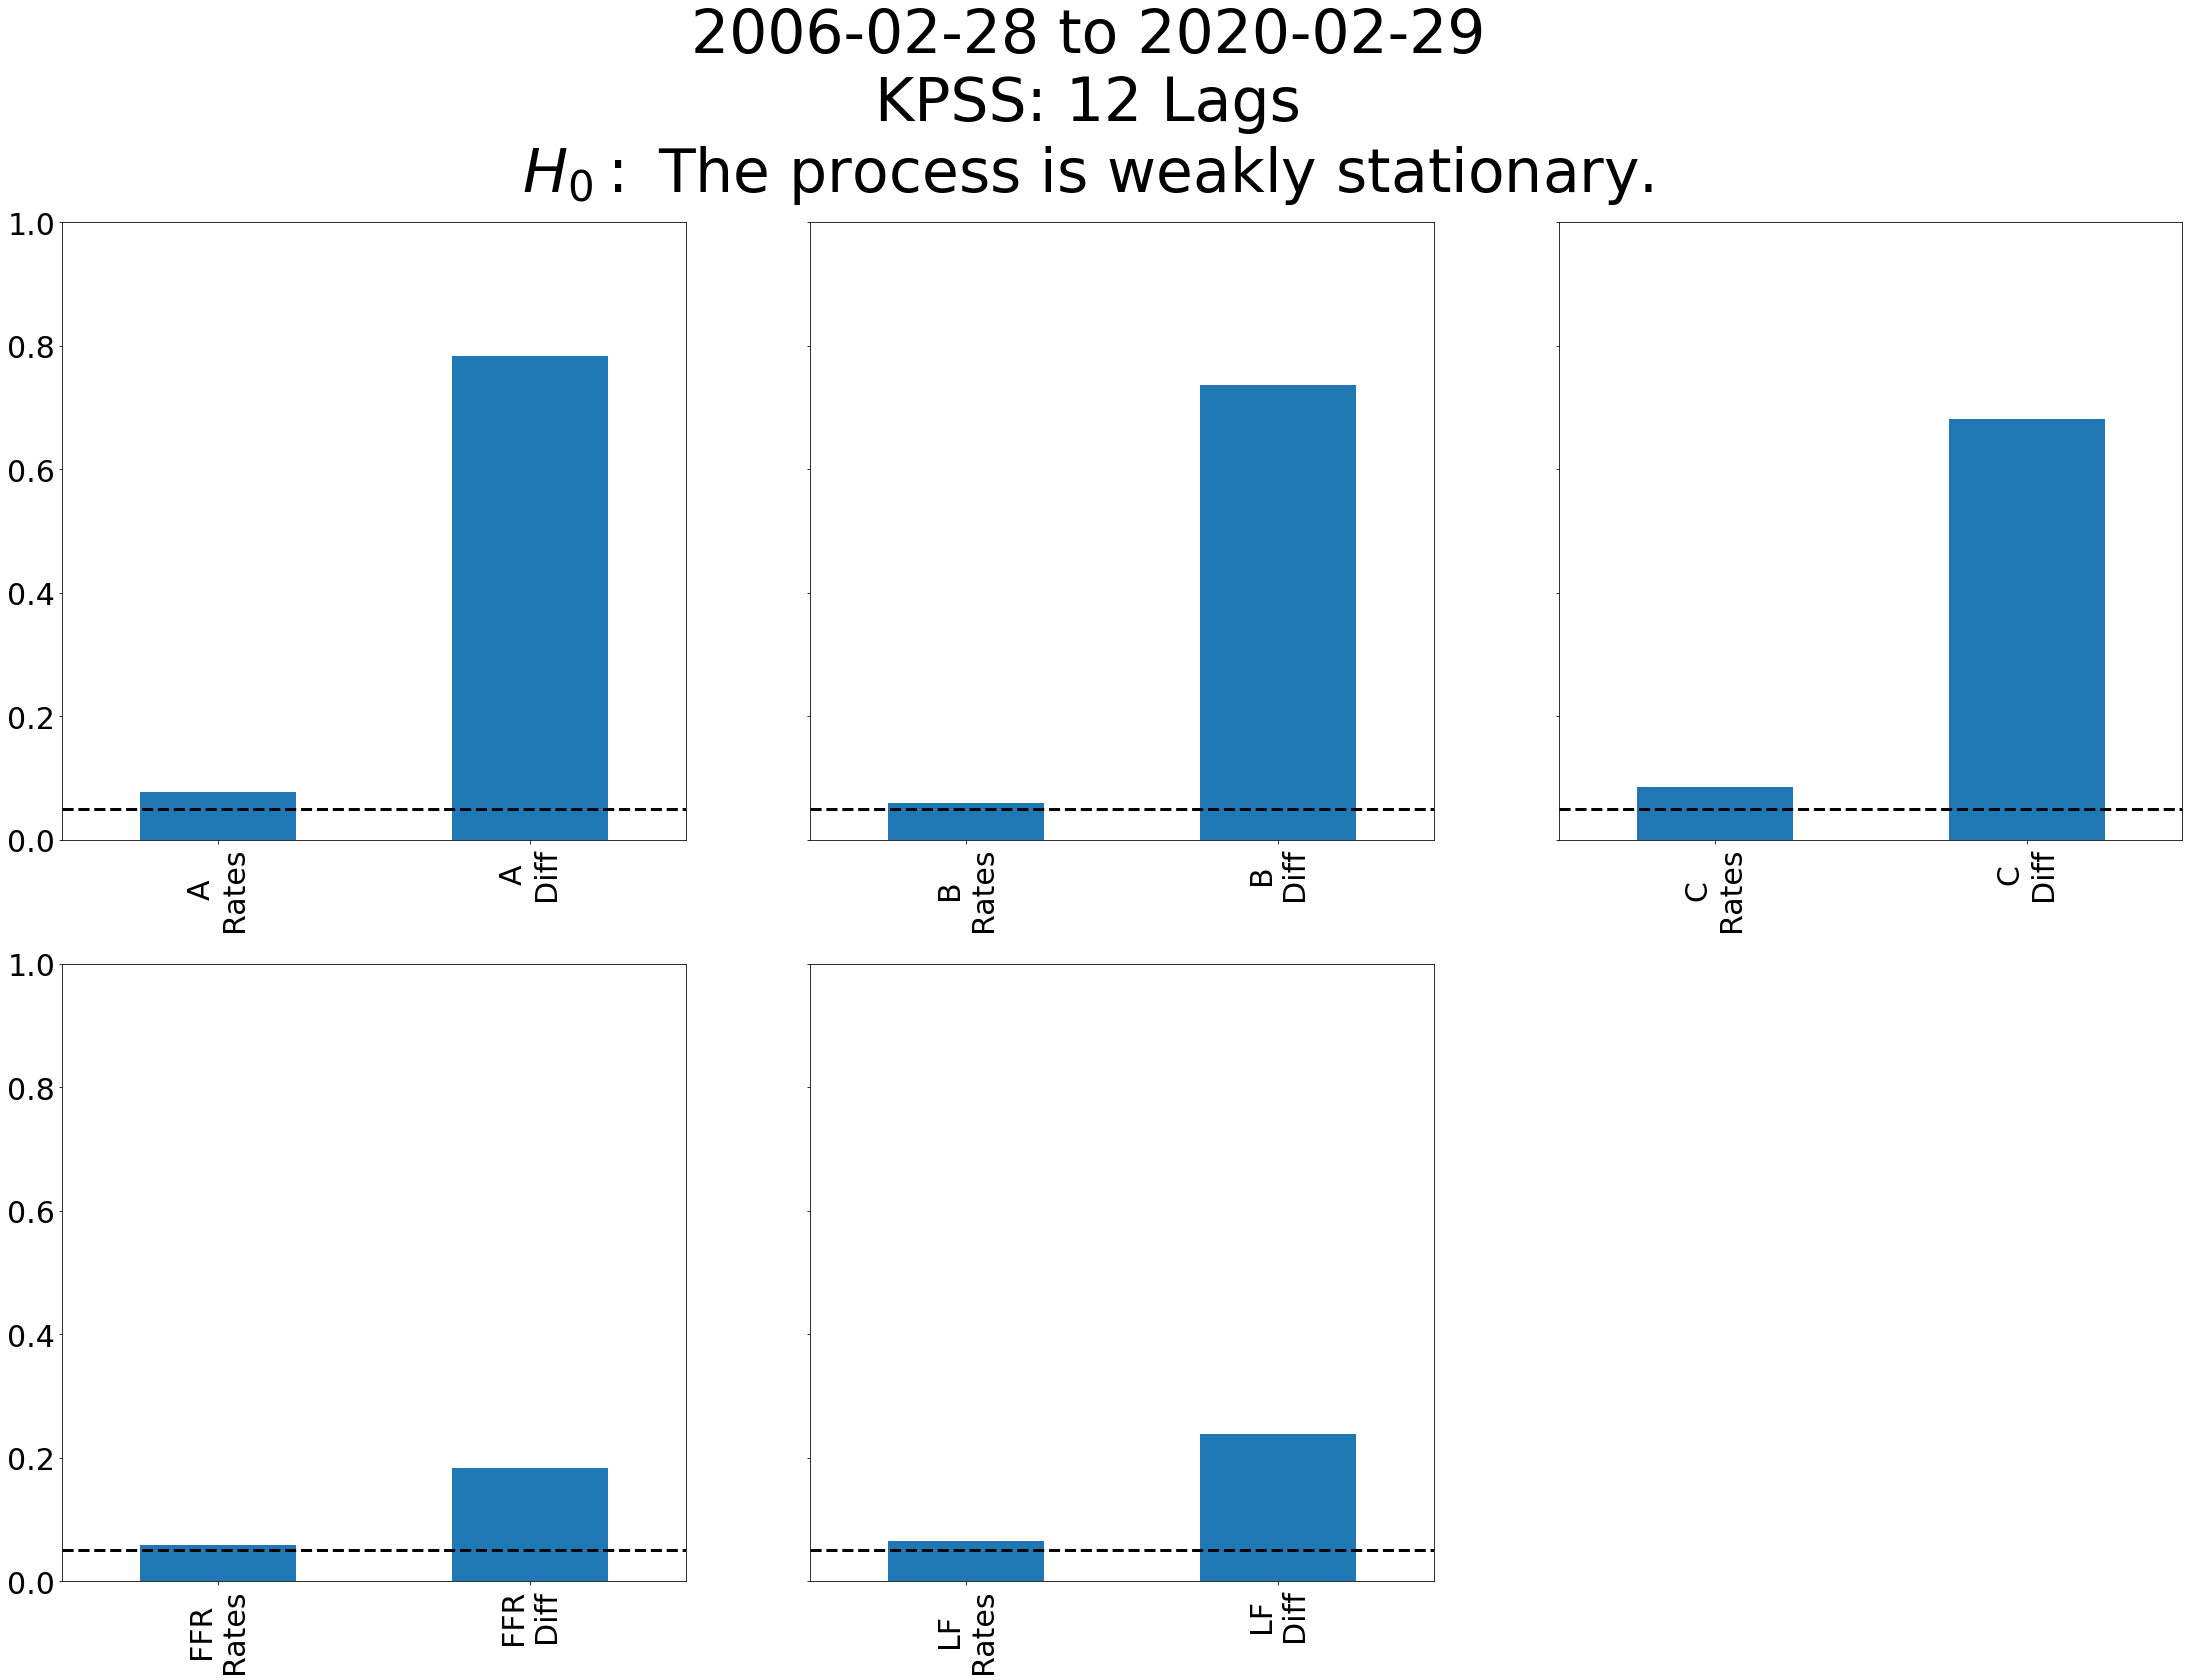

In [10]:
plt.rcParams.update({"font.size":30})
def run_ts_tests(data_dct, lags, adf_dct = {}, kpss_dct = {}):
    def build_result_dcts(): 
        for key in keys:
            adf_dct[key] = {}
            kpss_dct[key] = {}
            for diff in diffs:
                adf_dct[key][diff] = {}
                kpss_dct[key][diff] = {}   
        return adf_dct, kpss_dct
    
    diffs = list(data_dct.keys())
    keys = list(data_dct[diffs[0]].keys())
    print(keys)
    build_result_dcts()
    for diff in diffs:
        test_data = data_dct[diff][list(rename_dct.values())]
        test_data.dropna().to_csv("TestData"+diff+".csv")
        test_data = test_data.dropna()
        for key, val in test_data.items(): 
#             print(val)
            adf_dct[key][diff] = ADF(val, 
                                       lags = lags, 
                                       trend= "c").pvalue
            kpss_dct[key][diff] = KPSS(val, 
                                       lags = lags, 
                                       trend= "c").pvalue            
    return pd.DataFrame(adf_dct), pd.DataFrame(kpss_dct)

def bar_plots(dct, width = 2, length = 3,title = "", title_y = 1.05):
    
    fig, ax = plt.subplots(width,
                           length, 
                           figsize = (38,25))
 
    i = 0
    j = 0
    for key, df in dct.items():
        a = ax[j][i]
        df.plot.bar(ax = a,
                              legend = False)
        xtick_labels = a.get_xticks()
        a.axhline(.05, ls = "--", color = "k", linewidth = 3)
        a.set_xticklabels([key + "\n" + diff.replace("Diff-in-Diff","2-Diff") for diff in diffs],
                                fontsize = 30)
        a.set_ylim(0,1)

        if i == 0:
            a.set_yticklabels([round(y,2) for y in a.get_yticks()],
                                fontsize = 30)
        else:
            a.set_yticklabels(["" for y in a.get_yticks()])
        
        i+=1

        if i == length:
            i = 0
            j += 1
    ax[1][2].axis("off")
    fig.suptitle(title, y = title_y, fontsize = 60)
    fig.savefig(title.replace(":", "-").replace("$","").replace("\n","") + ".png")
    
def rename_vars(rename_data, rename_dct):
    for key in rename_data:
        for rename_key in rename_dct:
            if rename_key in key:
                rename_data.rename(columns={key:rename_dct[rename_key]}, inplace = True)
    
    return rename_data
  

rename_dct = {
              "Assets":"A",
#              "Circulation / Total":"C/A",
             "Total Base":"B",
              "Currency":"C",
                "Effective":"FFR",
              "Function":"LF"}
#              "Inflation":"$\pi_{Loss}$",
#              "Unemployment":"$U_{Loss}$"}
abbrev_keys = list(rename_dct.values())
lags = 1
# lags = year

test_vars = ["Effective Federal Funds Rate (%)",
        "Currency in Circulation",
        "Total Base",
             "Total Assets",
        "Loss Function"]

test_data_dct = {}
for diff in diffs:
    end_date =  "2020-02-29"#str(list(data["Diff"].index)[-1])[:10]#"2020-02-29"
    #     start_end_list = [(str(var_data.index[0])[:10],"2008-09-30"),
    start_end_list = [#(str(monthly_data[diff][test_vars].dropna().index[0])[:10],"2006-01-31"),                      
                      ("2006-02-28", end_date)]
#                           ("2006-02-28", "2020-02-29")]
#                           ("2010-10-31", end_date)]
#                           ("2014-01-31", end_date),
#                      ] 
        # test all variables, include loss function components
#     monthly_data[diff] = monthly_data[diff][test_vars].dropna().dropna()
#     data[diff] = data[diff][test_vars].dropna().dropna()
    #     adf_data = monthly_data[diff][test_vars]

    test_data_dct[diff] = copy.copy(rename_vars(data[diff][test_vars], rename_dct))
#     data[diff] = rename_vars(data[diff][test_vars], rename_dct)
for start, end in start_end_list:
    test_data = {}
#     for key in test_vars:
#         for rename_key in rename_dct:
#             if rename_key in key:
#                 monthly_data[diff].rename(columns={key:rename_dct[rename_key] for rename_key in rename_dct if rename_key in key},
#                                 inplace = True) 
#                 data[diff].rename(columns={key:rename_dct[rename_key] for rename_key in rename_dct if rename_key in key},
#                                 inplace = True) 

    for diff in diffs:
        test_data[diff] = test_data_dct[diff][abbrev_keys].loc[start:end].dropna()
    for lags in [year]:#[1,year]:
        adf_df, kpss_df = run_ts_tests(test_data, lags)
        # plot_ADF tests
        # create filler val to get null hypothesis
        val = [i for i in range(10)]
        title = start + " to " + end + "\nADF: " + str(lags) + " Lags\n$H_0:$ "+ ADF(val,
                           lags = lags,
                           trend = "c").null_hypothesis + "\n"
        title_y = 1
        # ADF Commented Out, only include KPSS
#         bar_plots(adf_df, title = title, title_y = title_y)
        # plot KPSS tests
        title = start + " to " + end +  "\nKPSS: " + str(lags) + " Lags\n$H_0:$ "+  KPSS(val,
                               lags = lags,
                               trend = "c").null_hypothesis + "\n"
        bar_plots(kpss_df, title = title, title_y = title_y)


### ACF plots by difference

A DATE
2006-02-28    0.040691
2006-03-31    0.044104
2006-04-30    0.041959
2006-05-31    0.044699
2006-06-30    0.040272
                ...   
2019-10-31   -0.048624
2019-11-30   -0.019641
2019-12-31    0.007901
2020-01-31    0.026548
2020-02-29    0.040924
Freq: M, Name: A, Length: 169, dtype: float64
B DATE
2006-02-28    0.040568
2006-03-31    0.046232
2006-04-30    0.042538
2006-05-31    0.045571
2006-06-30    0.039802
                ...   
2019-10-31   -0.079200
2019-11-30   -0.047330
2019-12-31    0.007558
2020-01-31    0.028192
2020-02-29    0.029673
Freq: M, Name: B, Length: 169, dtype: float64
C DATE
2006-02-28    0.045572
2006-03-31    0.047812
2006-04-30    0.047779
2006-05-31    0.051831
2006-06-30    0.044145
                ...   
2019-10-31    0.045882
2019-11-30    0.048185
2019-12-31    0.049918
2020-01-31    0.050889
2020-02-29    0.050356
Freq: M, Name: C, Length: 169, dtype: float64
FFR DATE
2006-02-28    4.491429
2006-03-31    4.589355
2006-04-30    4.790333
2006

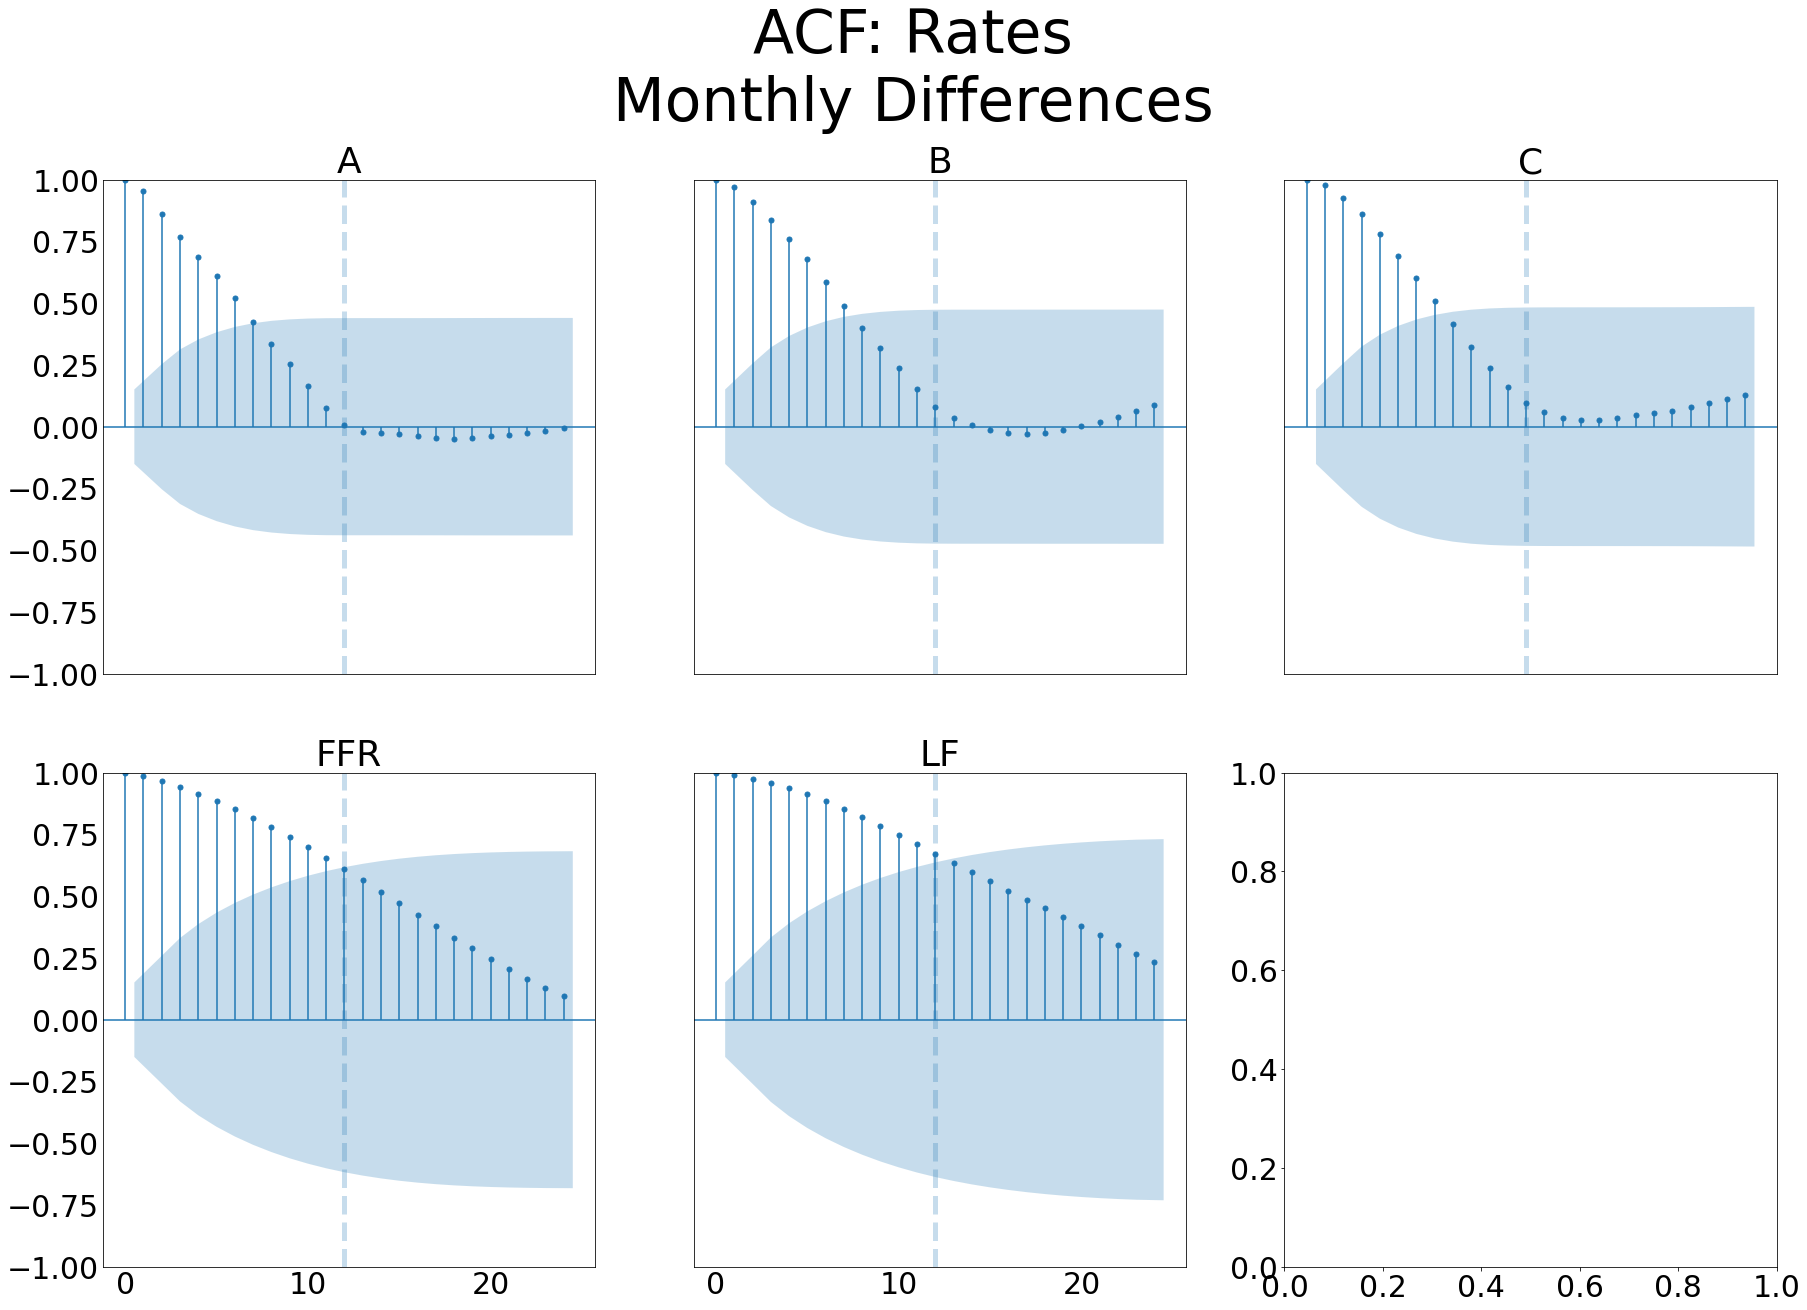

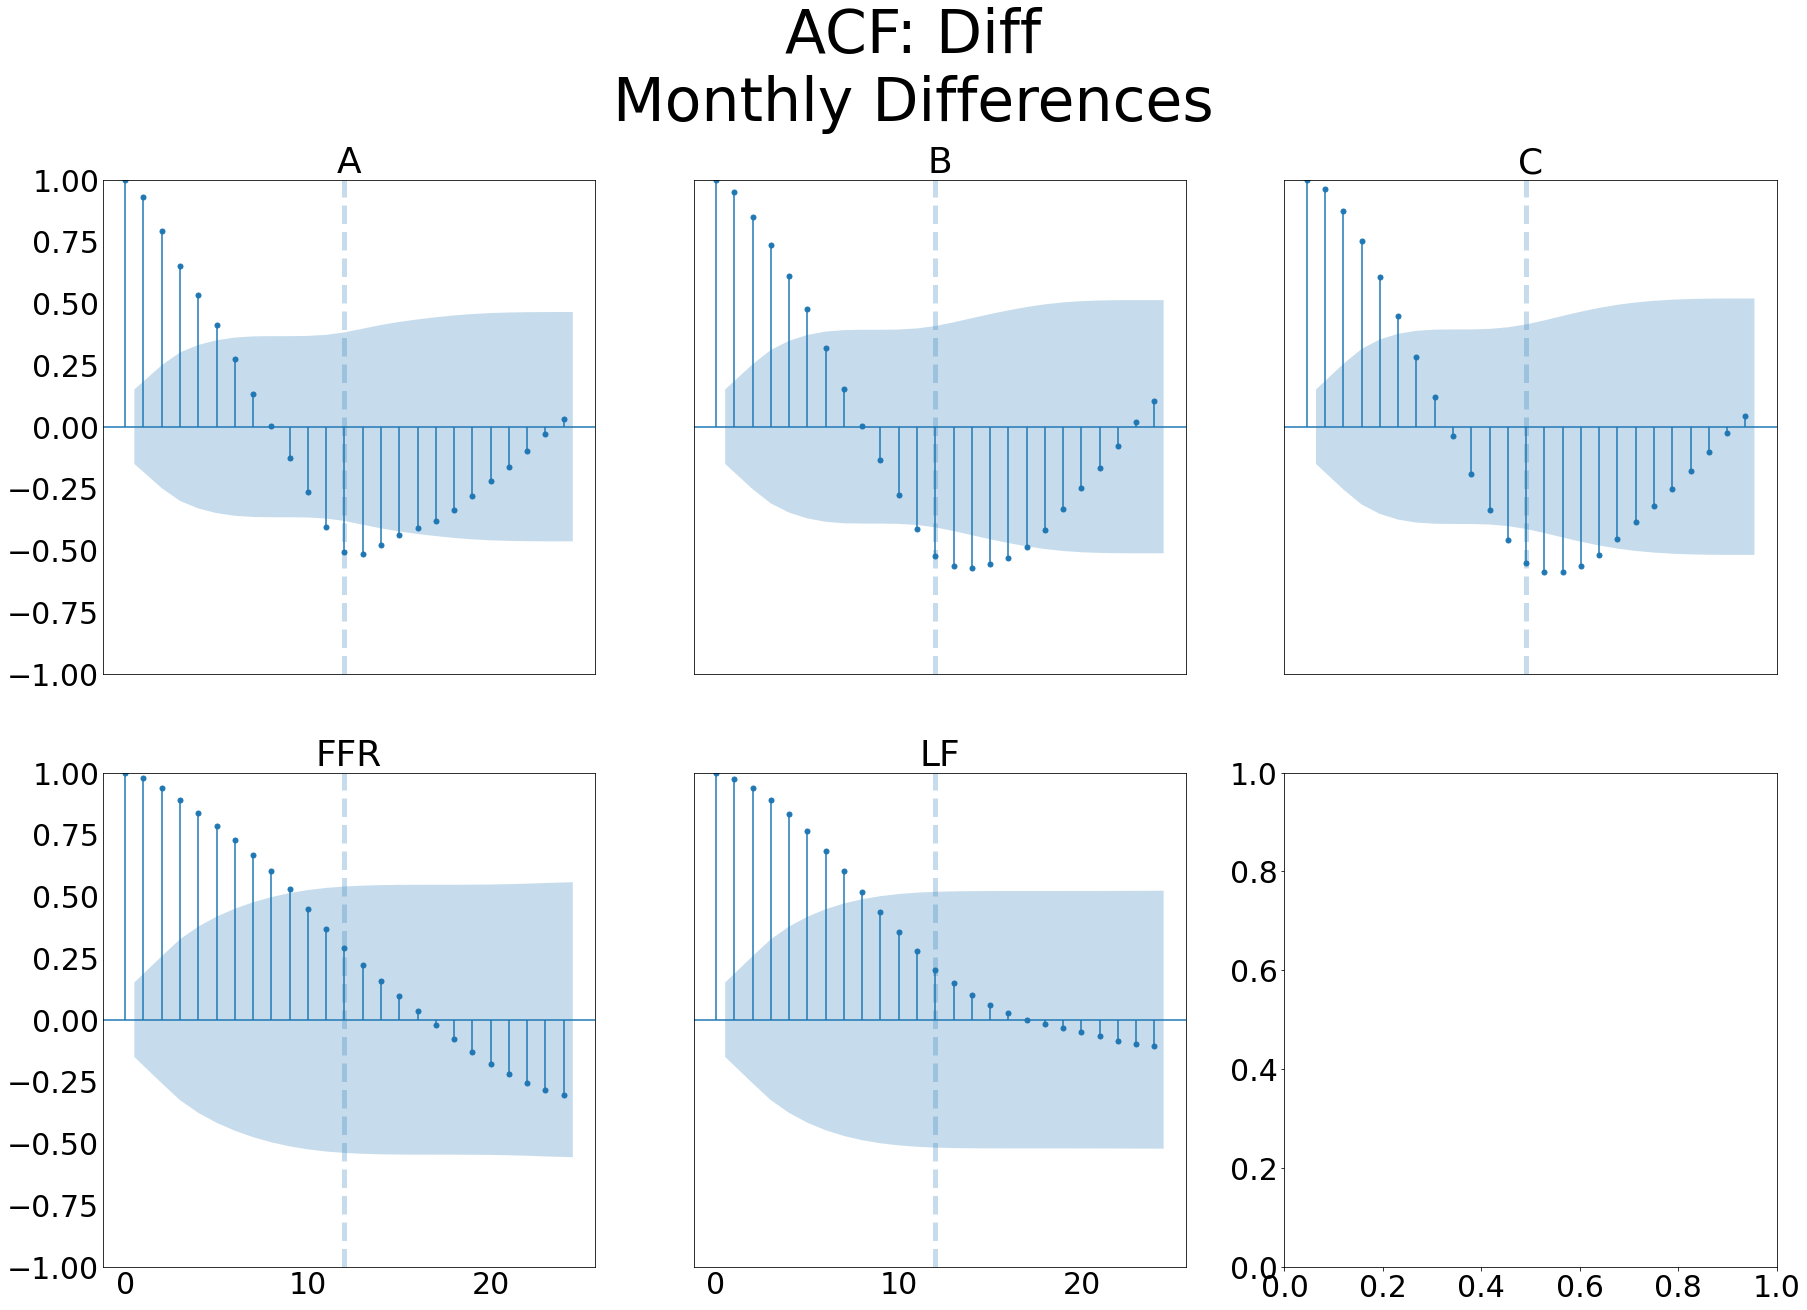

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
width, length = 3,2 

for diff in diffs:
    fig,ax = plt.subplots(length, width,figsize = (30,20))
    i, j = 0, 0
    for key in rename_dct.values():
        val = test_data[diff][key]
        print(key, val)
        a = ax[i][j]
        a.axvline(year, ls = "--", linewidth = 5, color = "C0", alpha = .25)
        plot_acf(val, title = key, ax = a, lags = 2 * year, bartlett_confint = True)
        a.tick_params(axis=u'both', which=u'both',length=0)

        if j > 0:
            a.set_yticklabels([])
        if i < length - 1:
            a.set_xticklabels([])
     
        j+=1

        if j == width:
            j = 0
            i += 1
    fig.suptitle("ACF: " + diff + "\nMonthly Differences", fontsize = 60, y = 1)
    fig.savefig("Figures/ACFMonthly"+ diff + ".png")


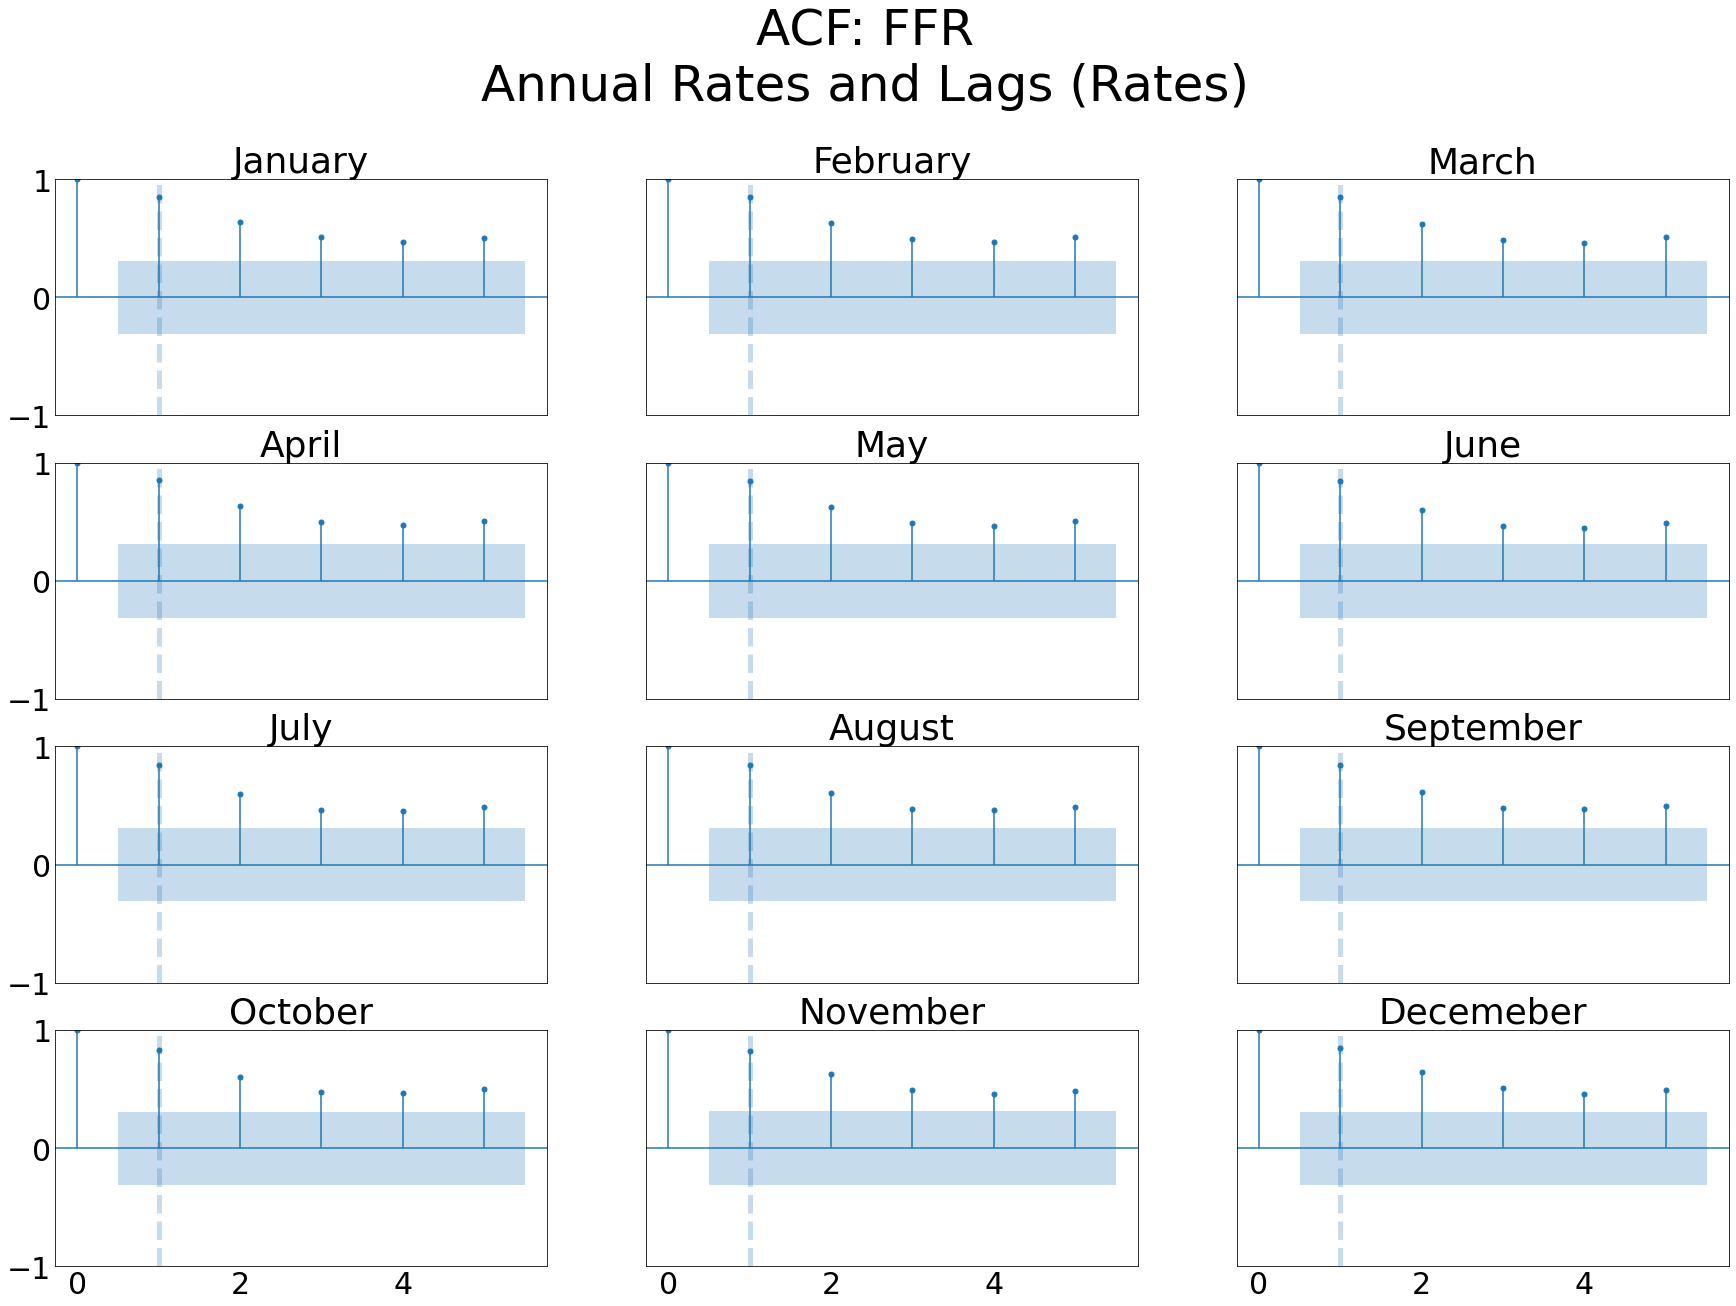

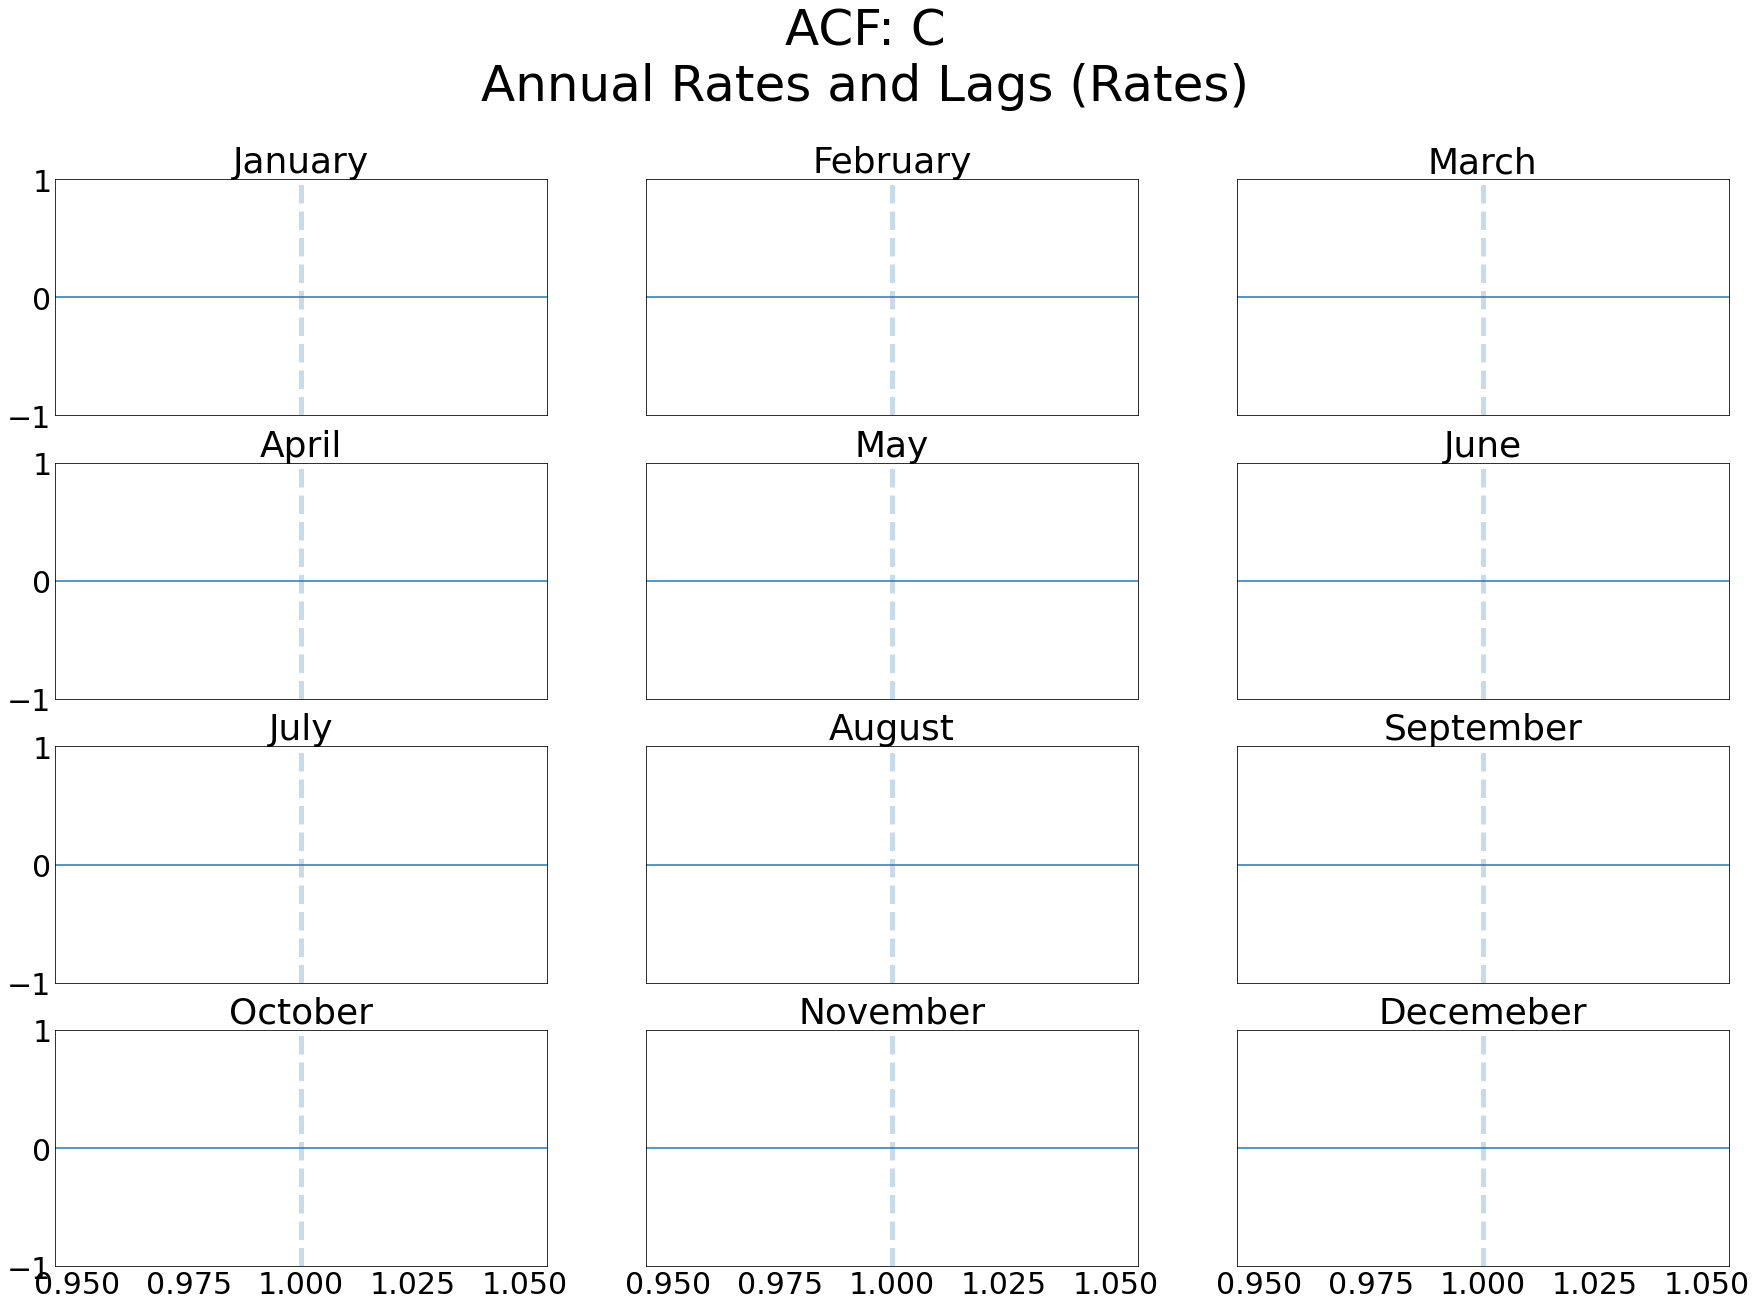

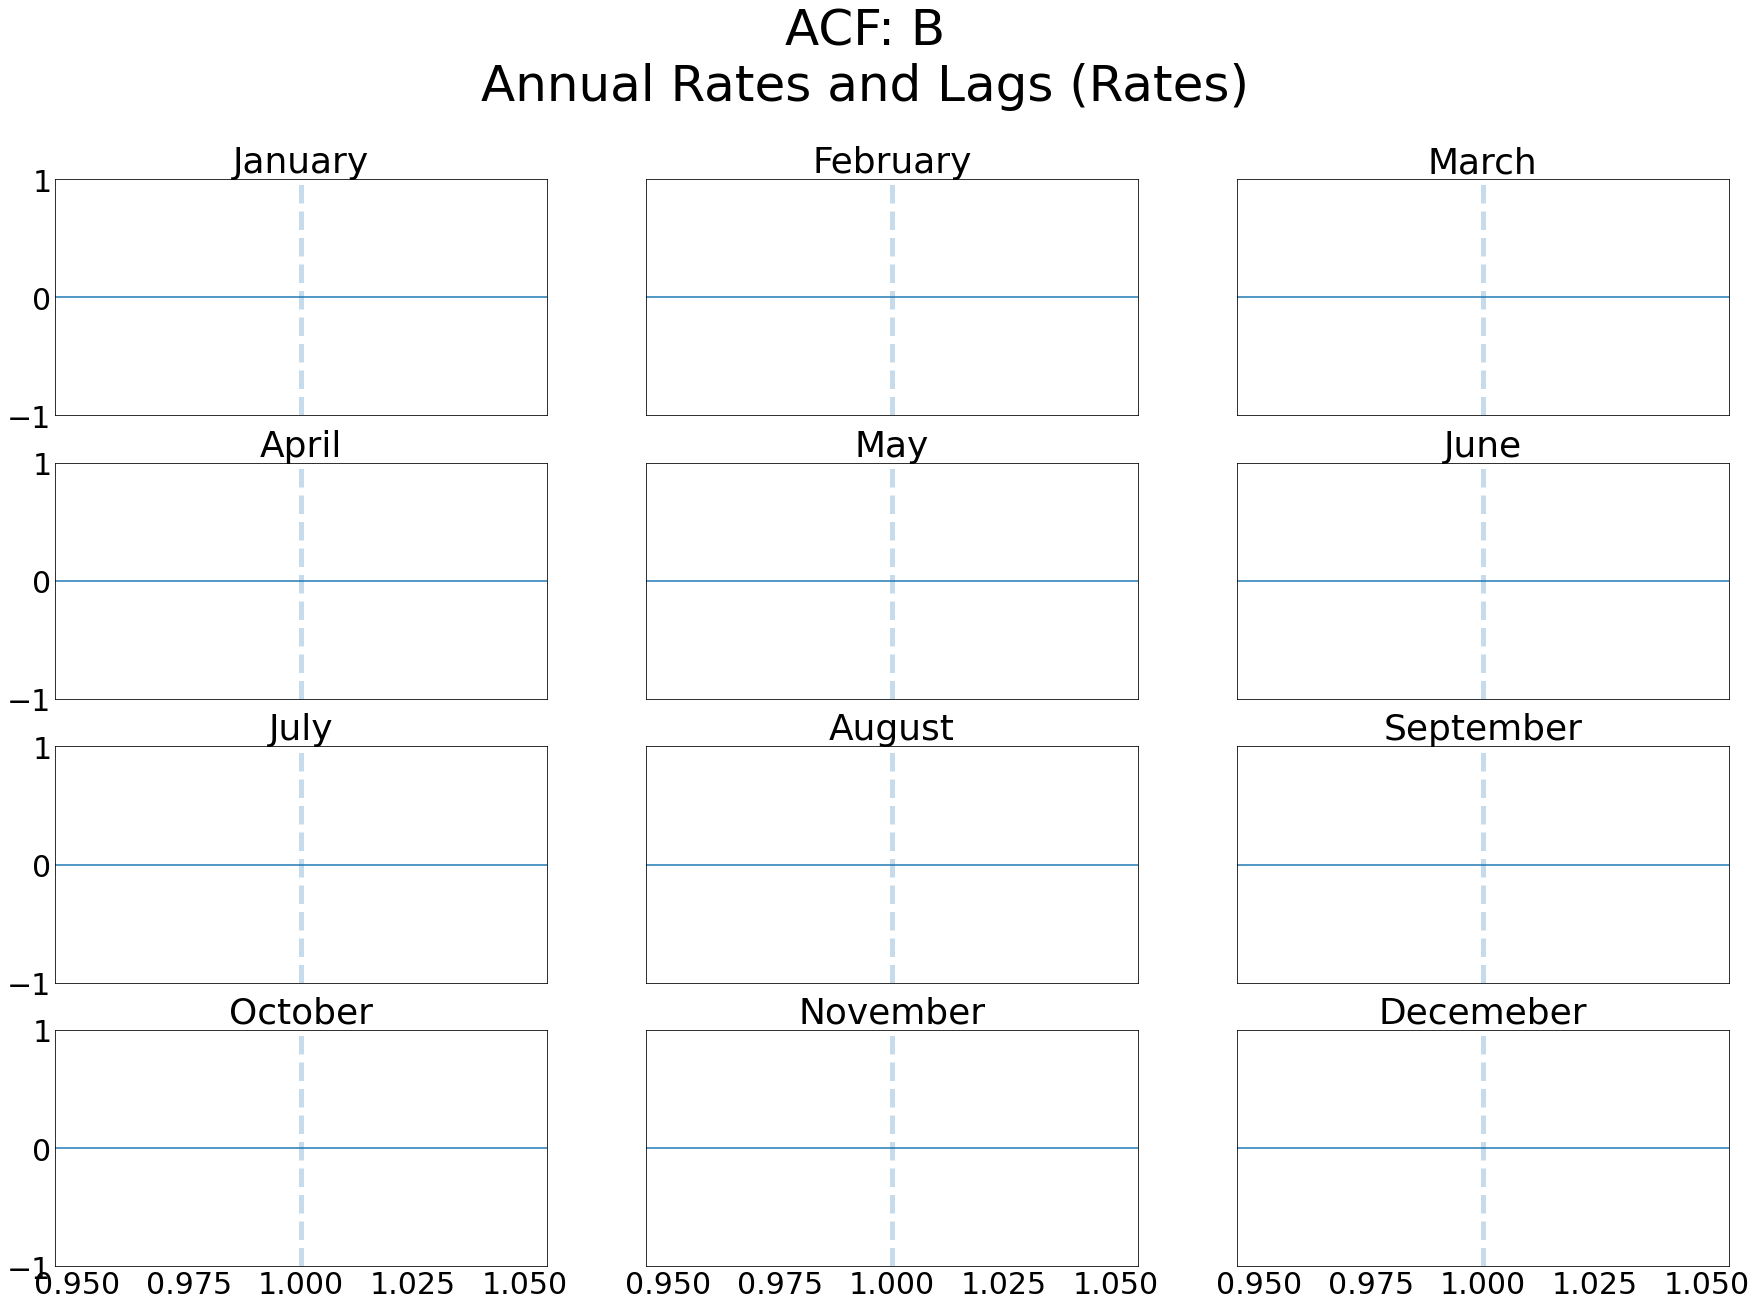

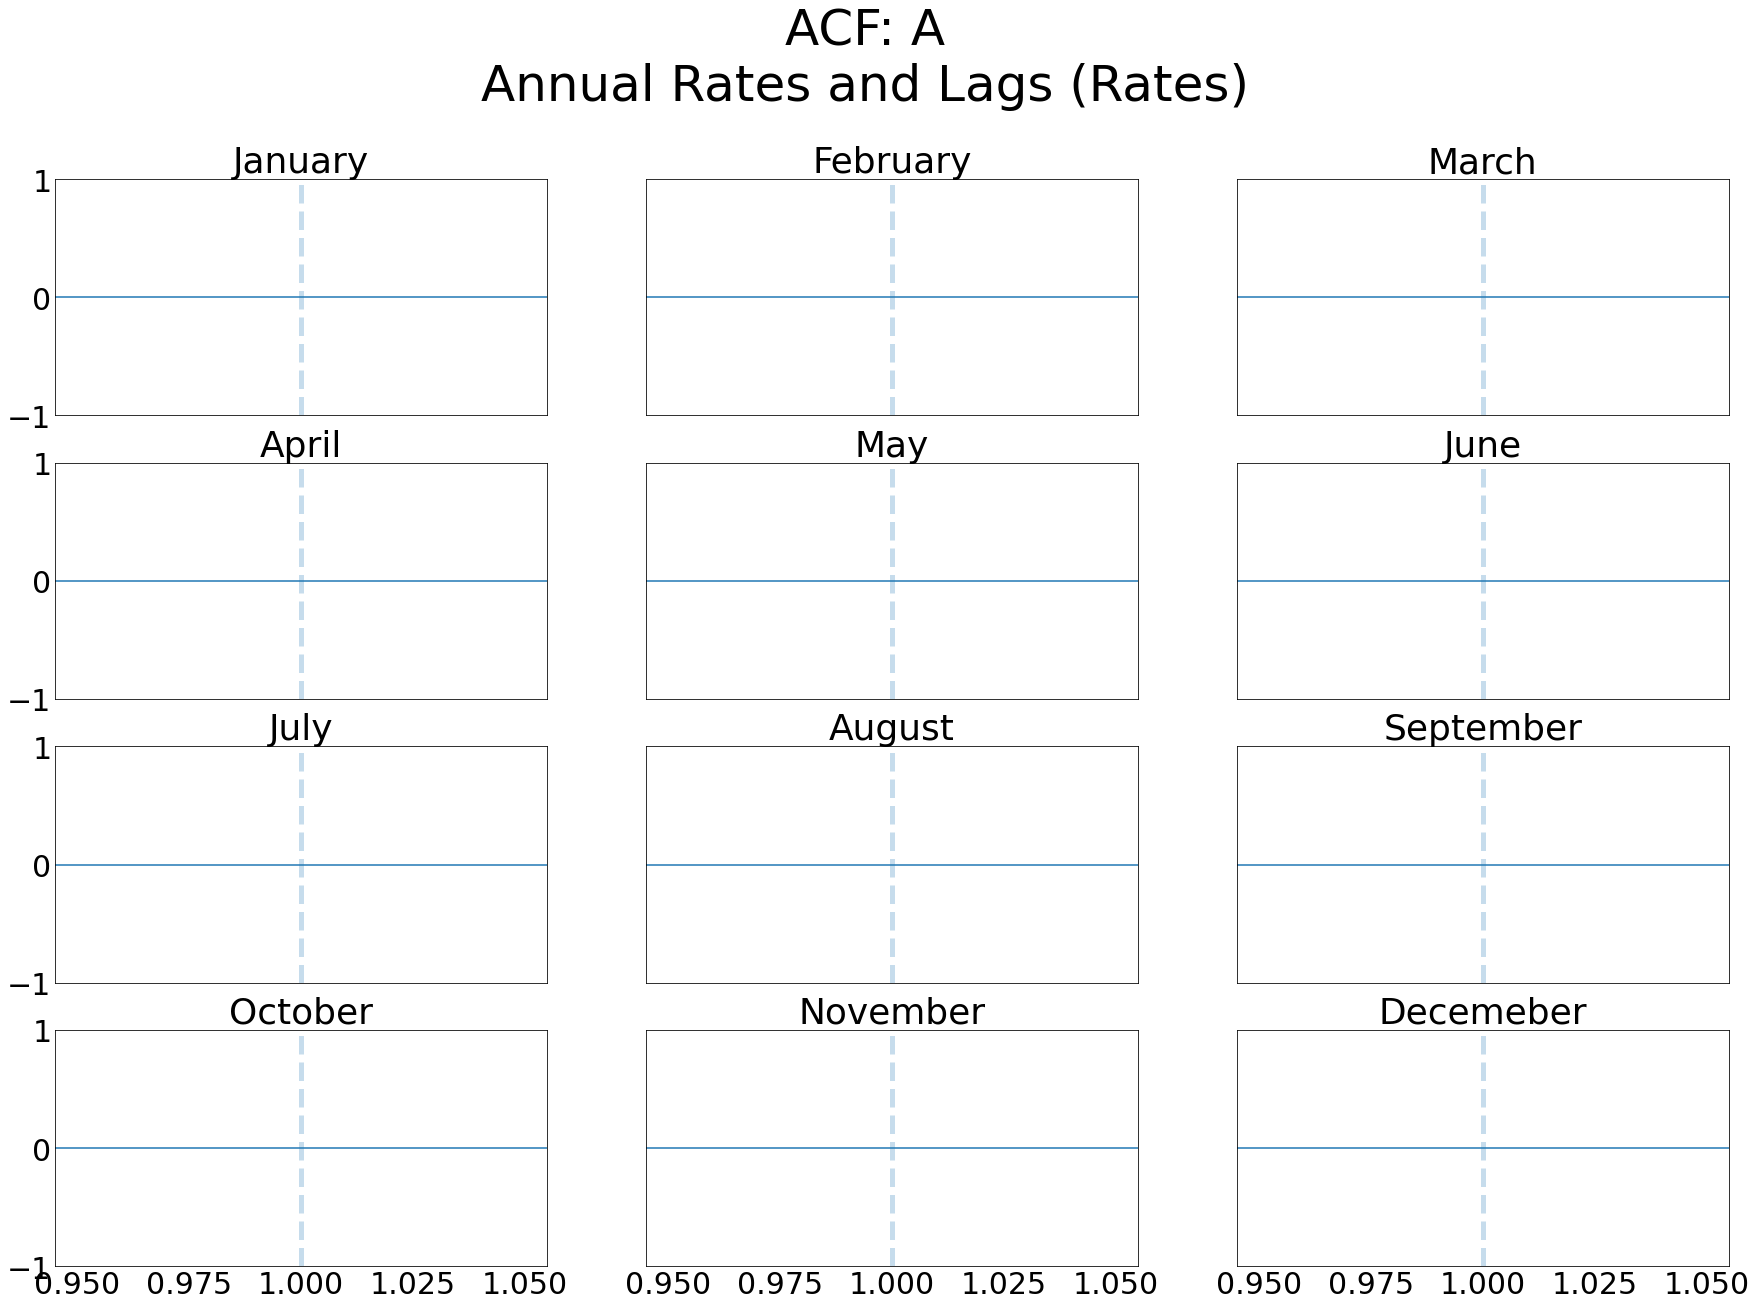

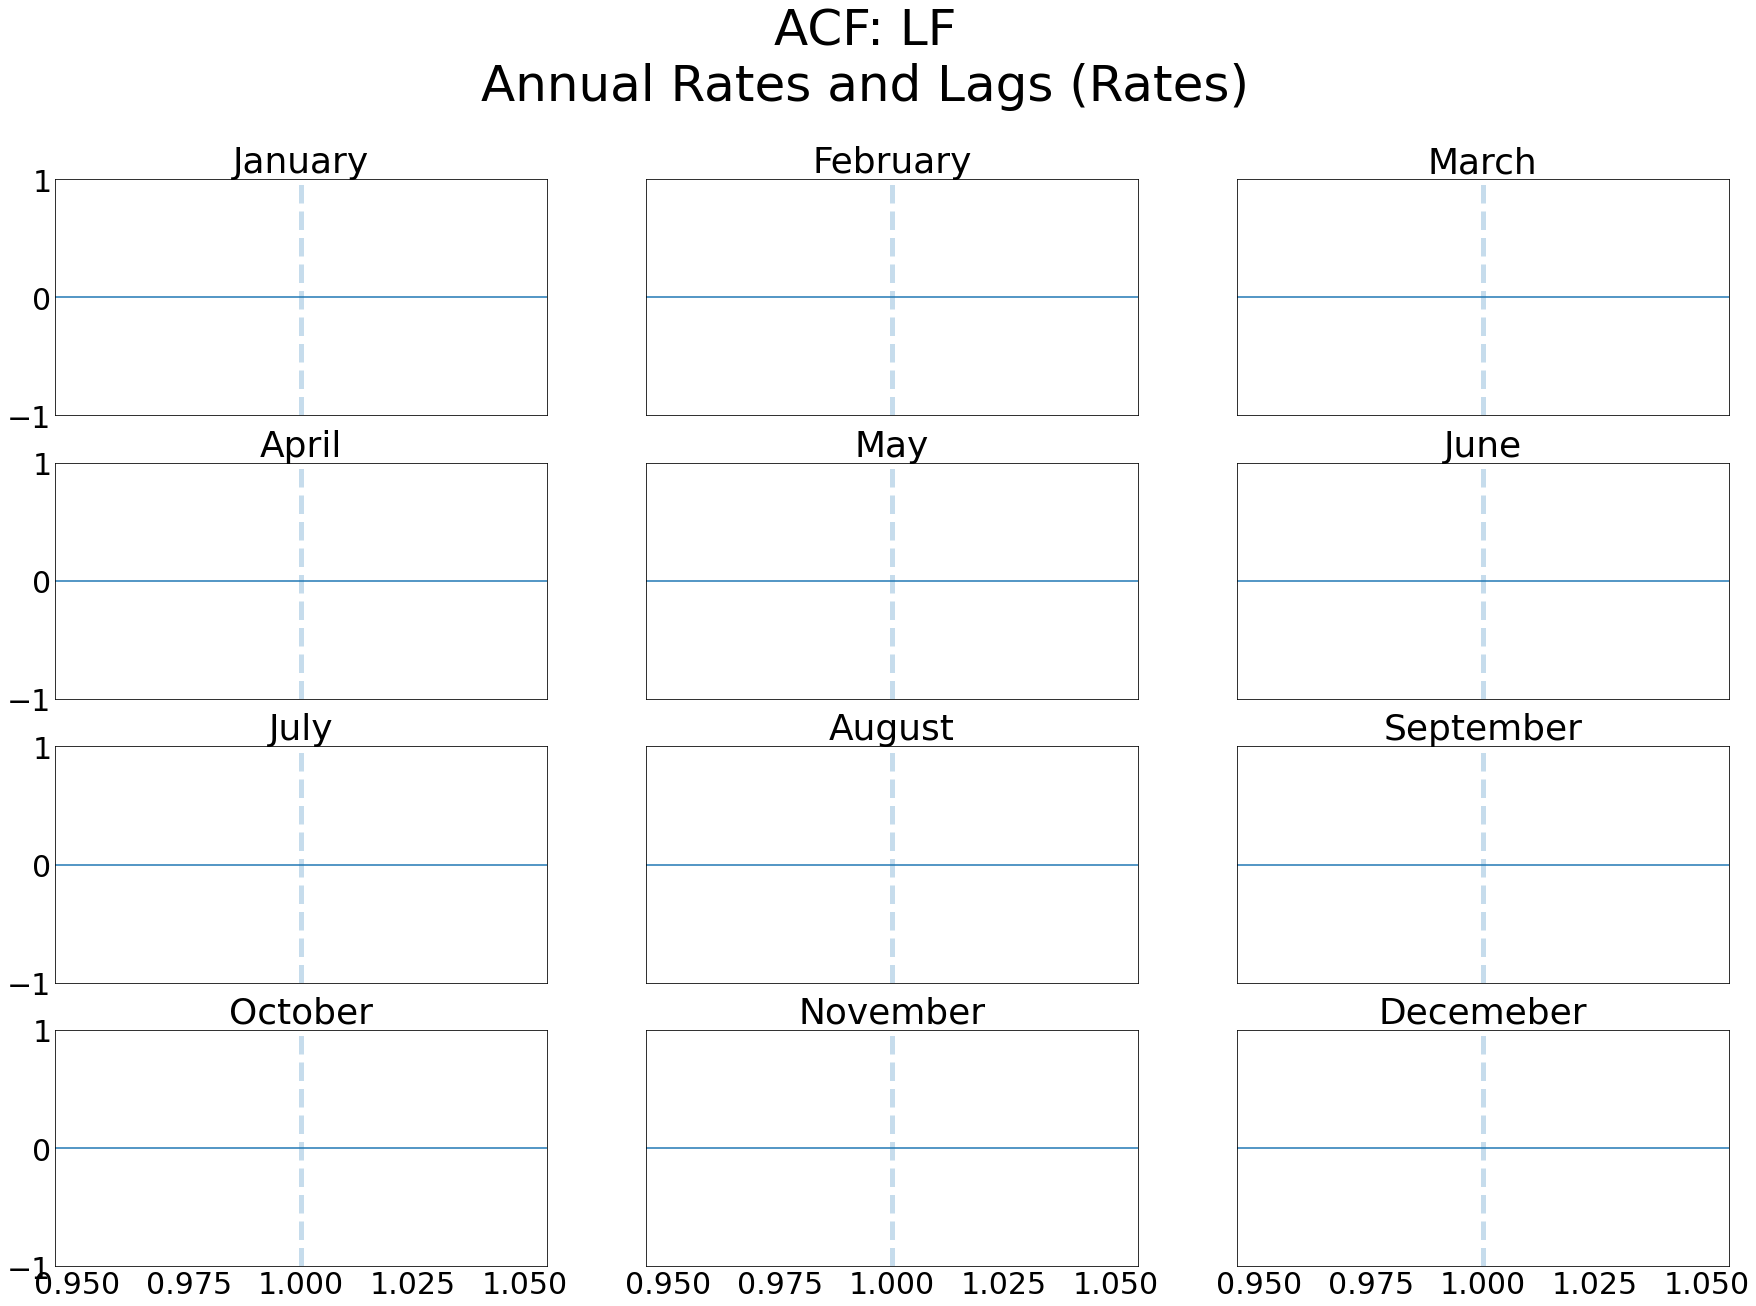

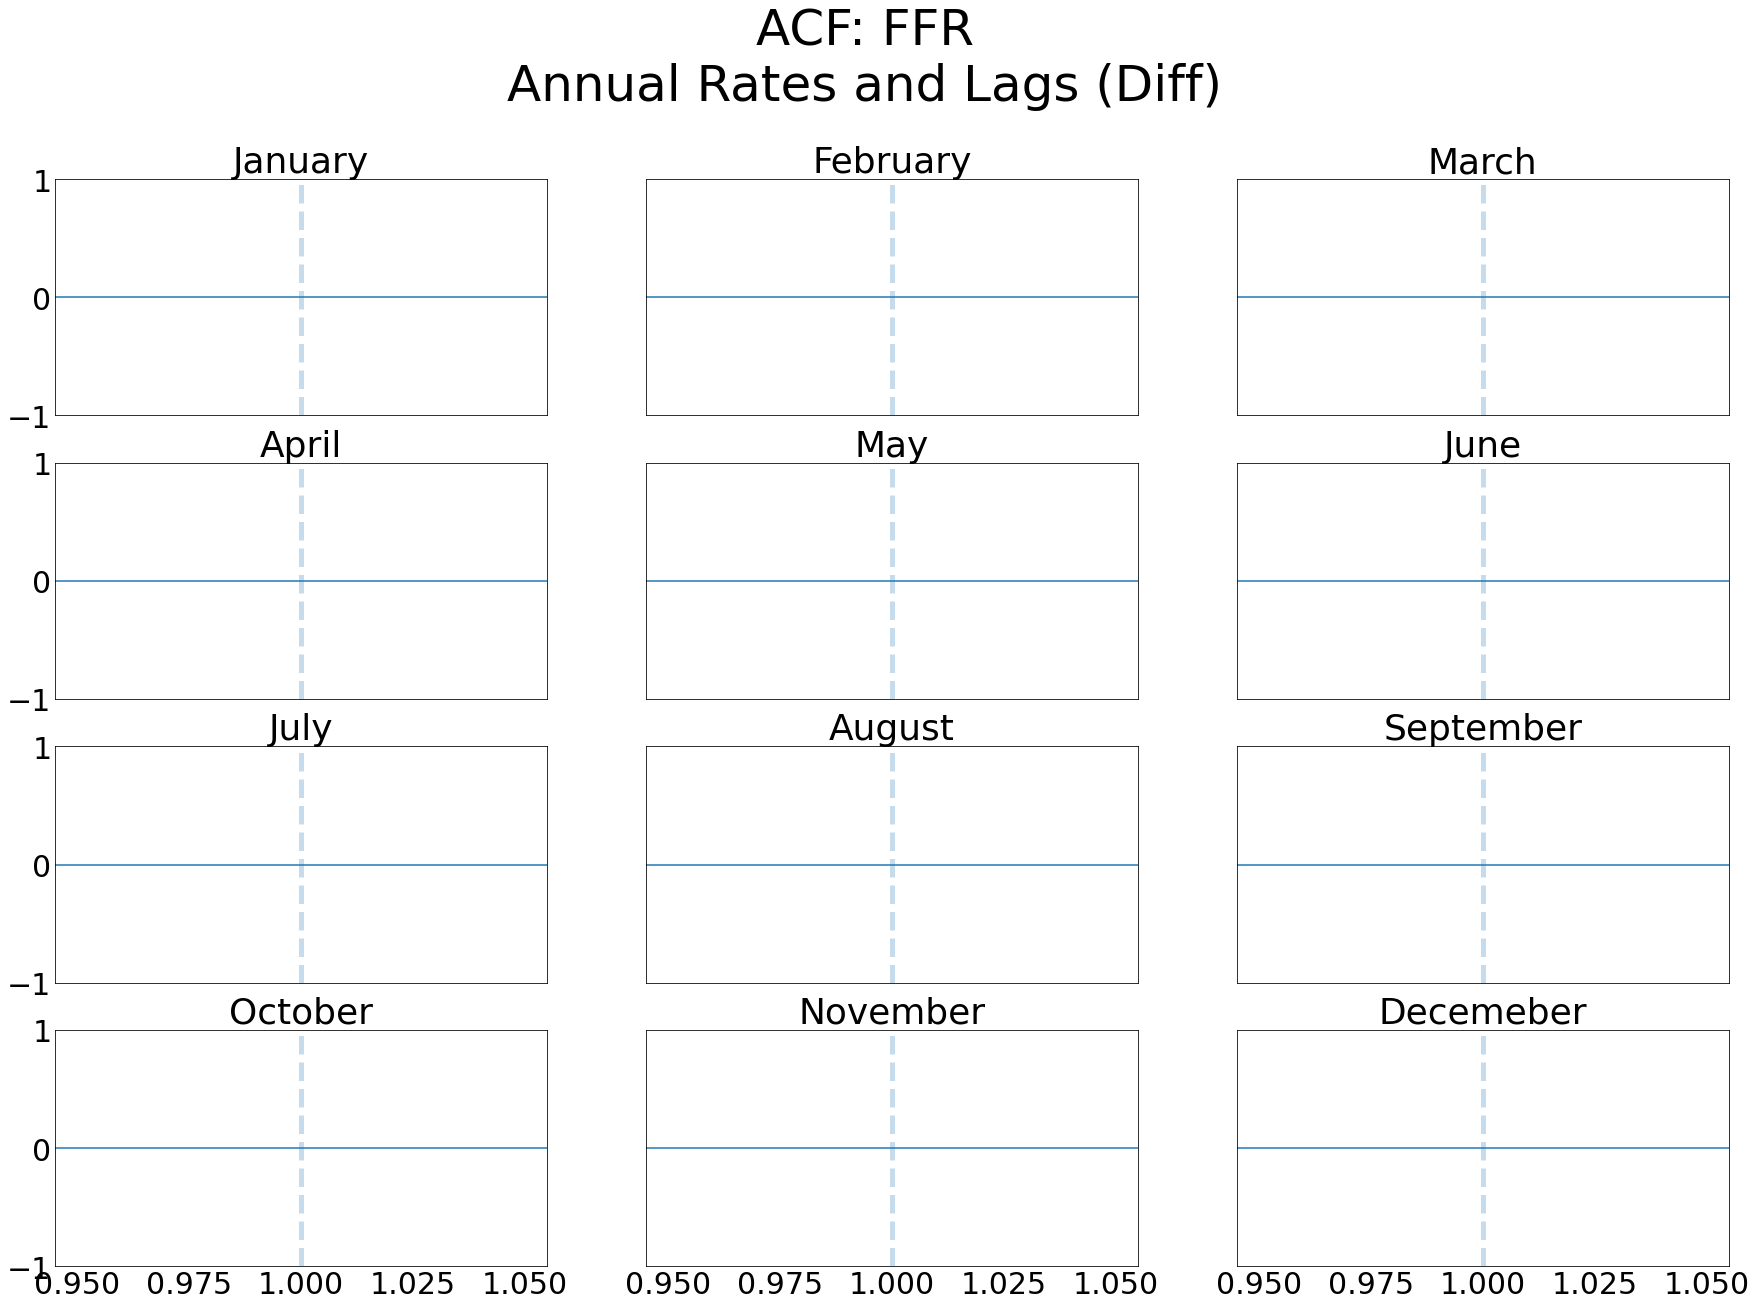

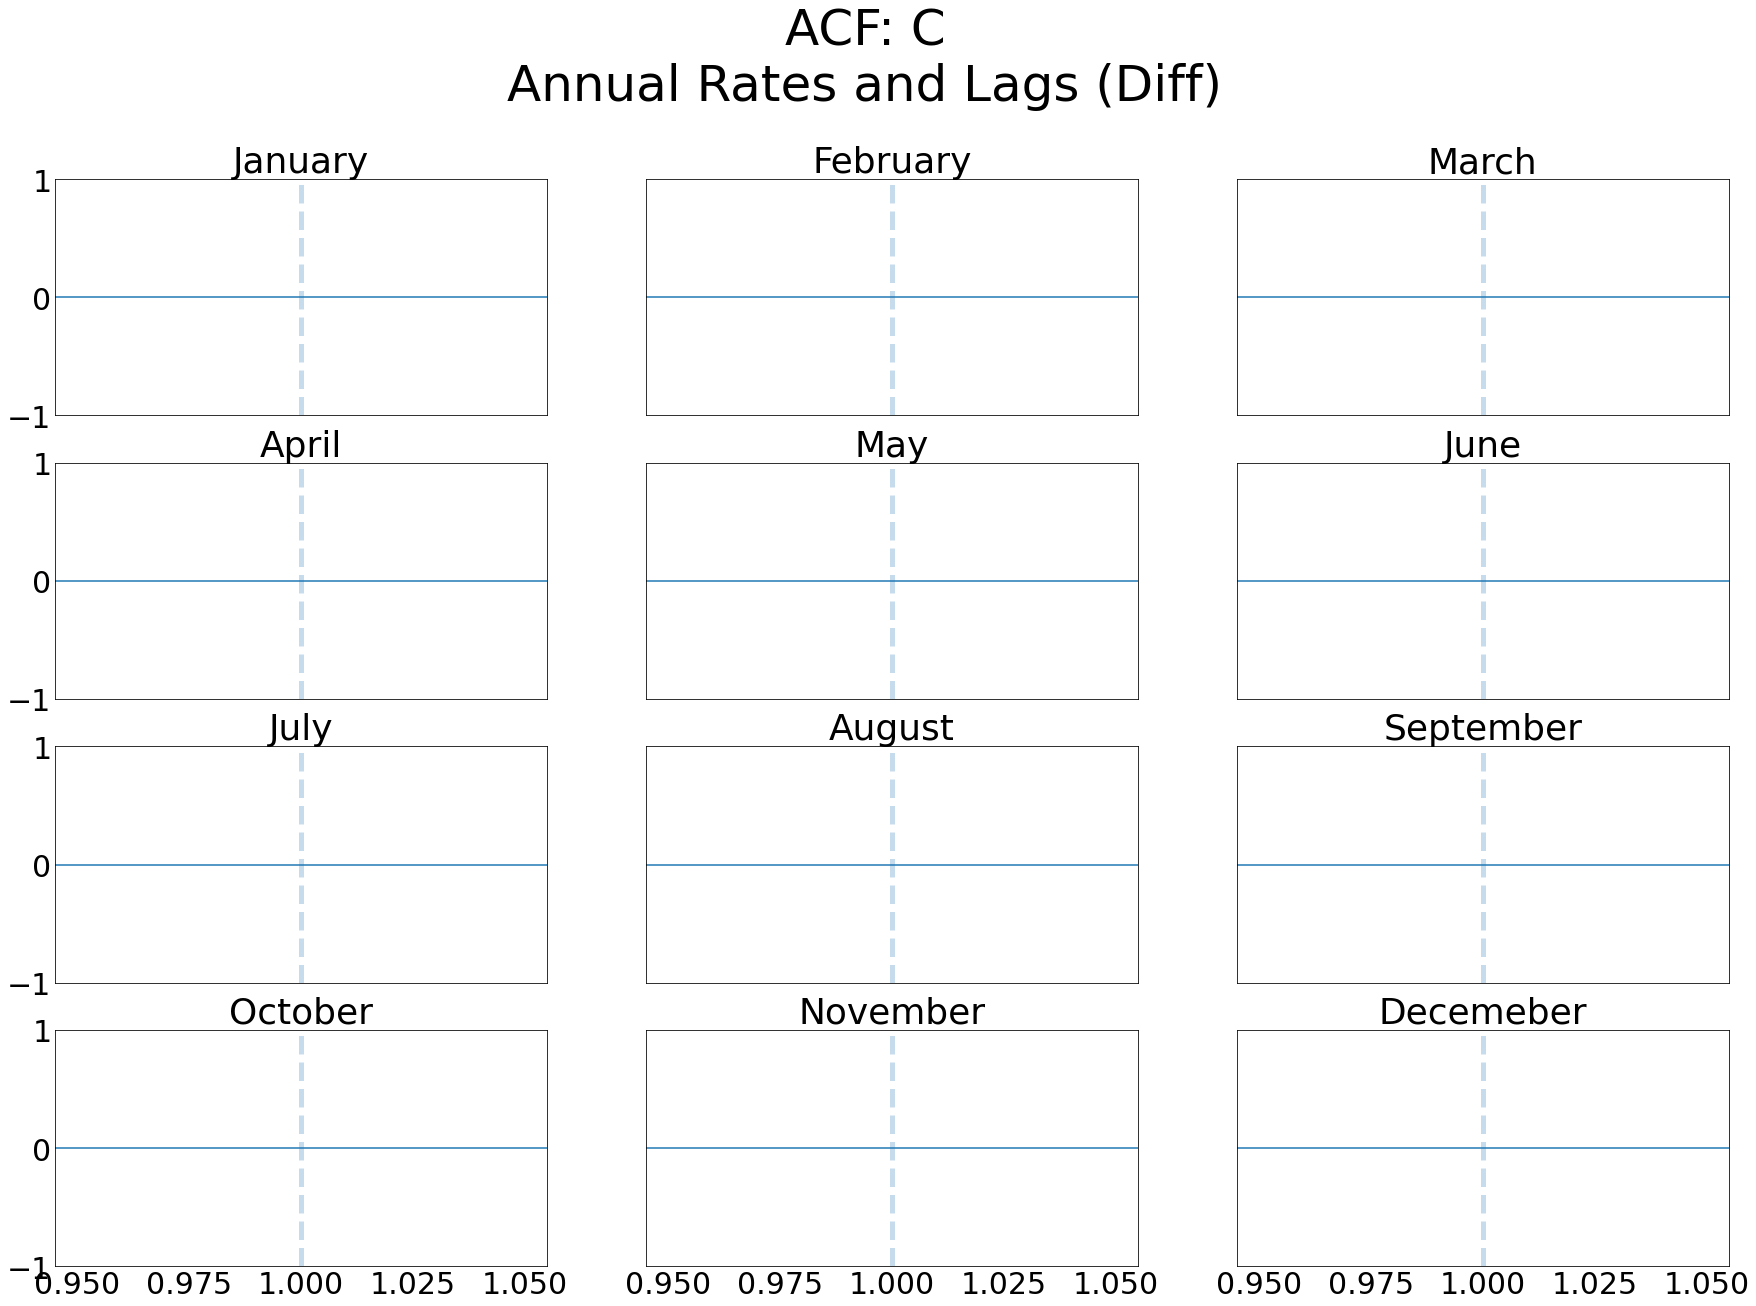

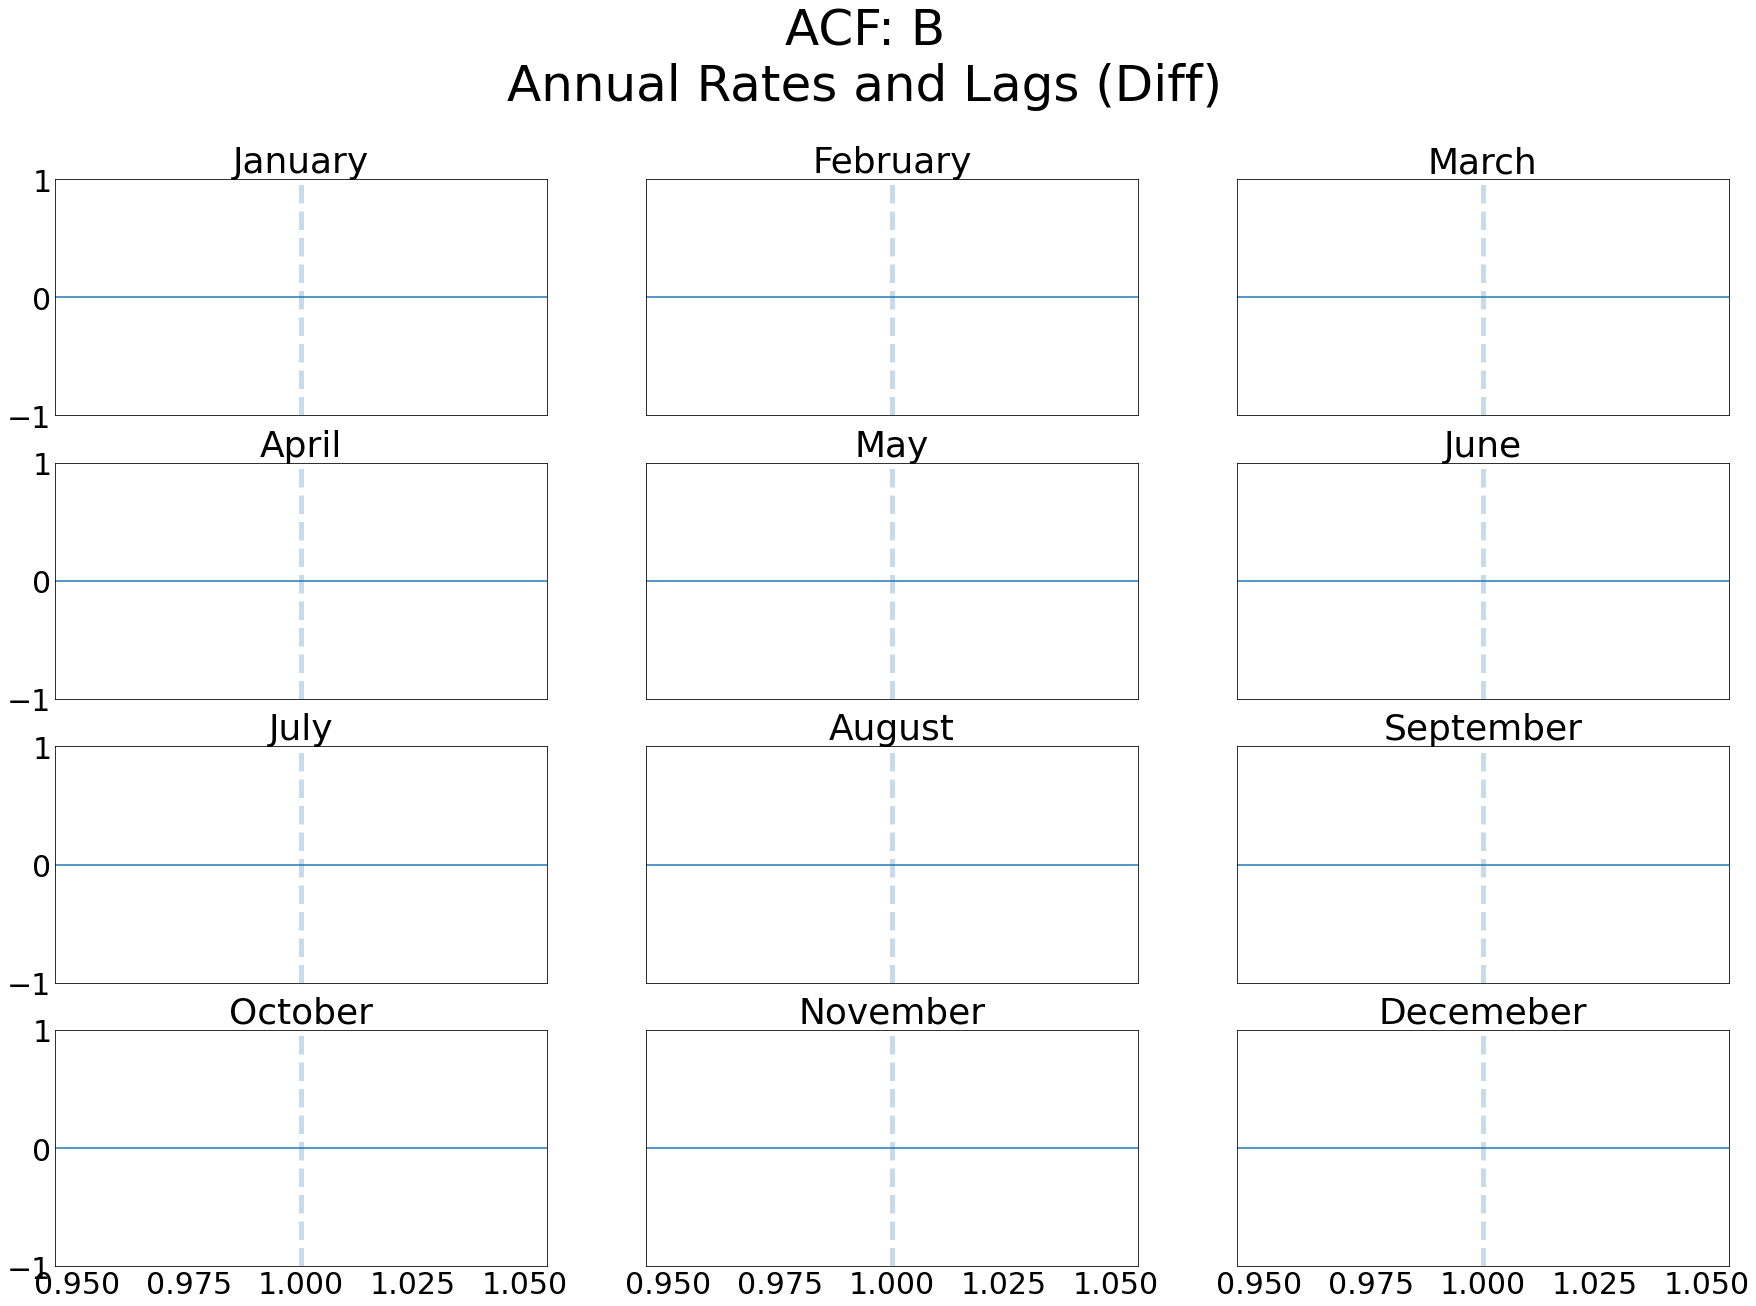

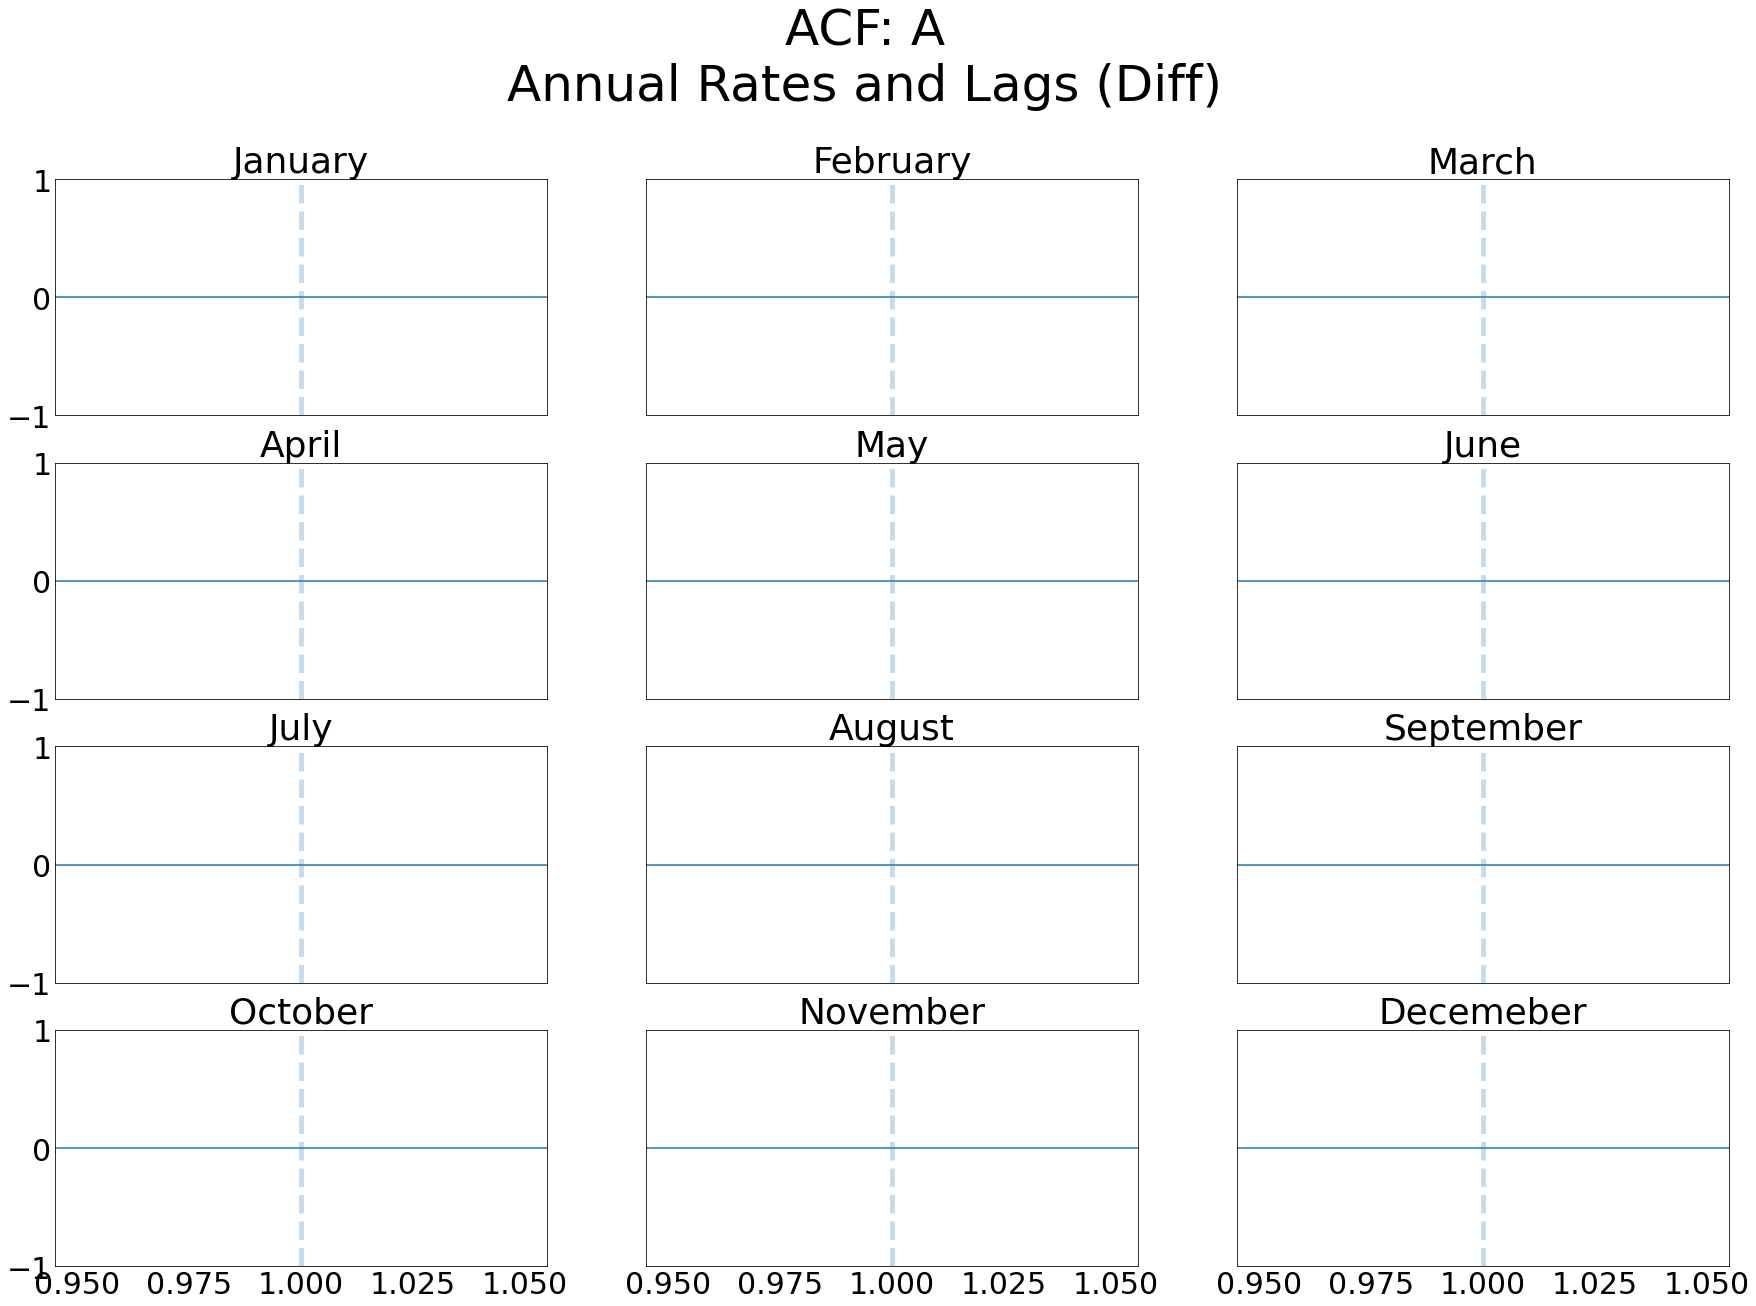

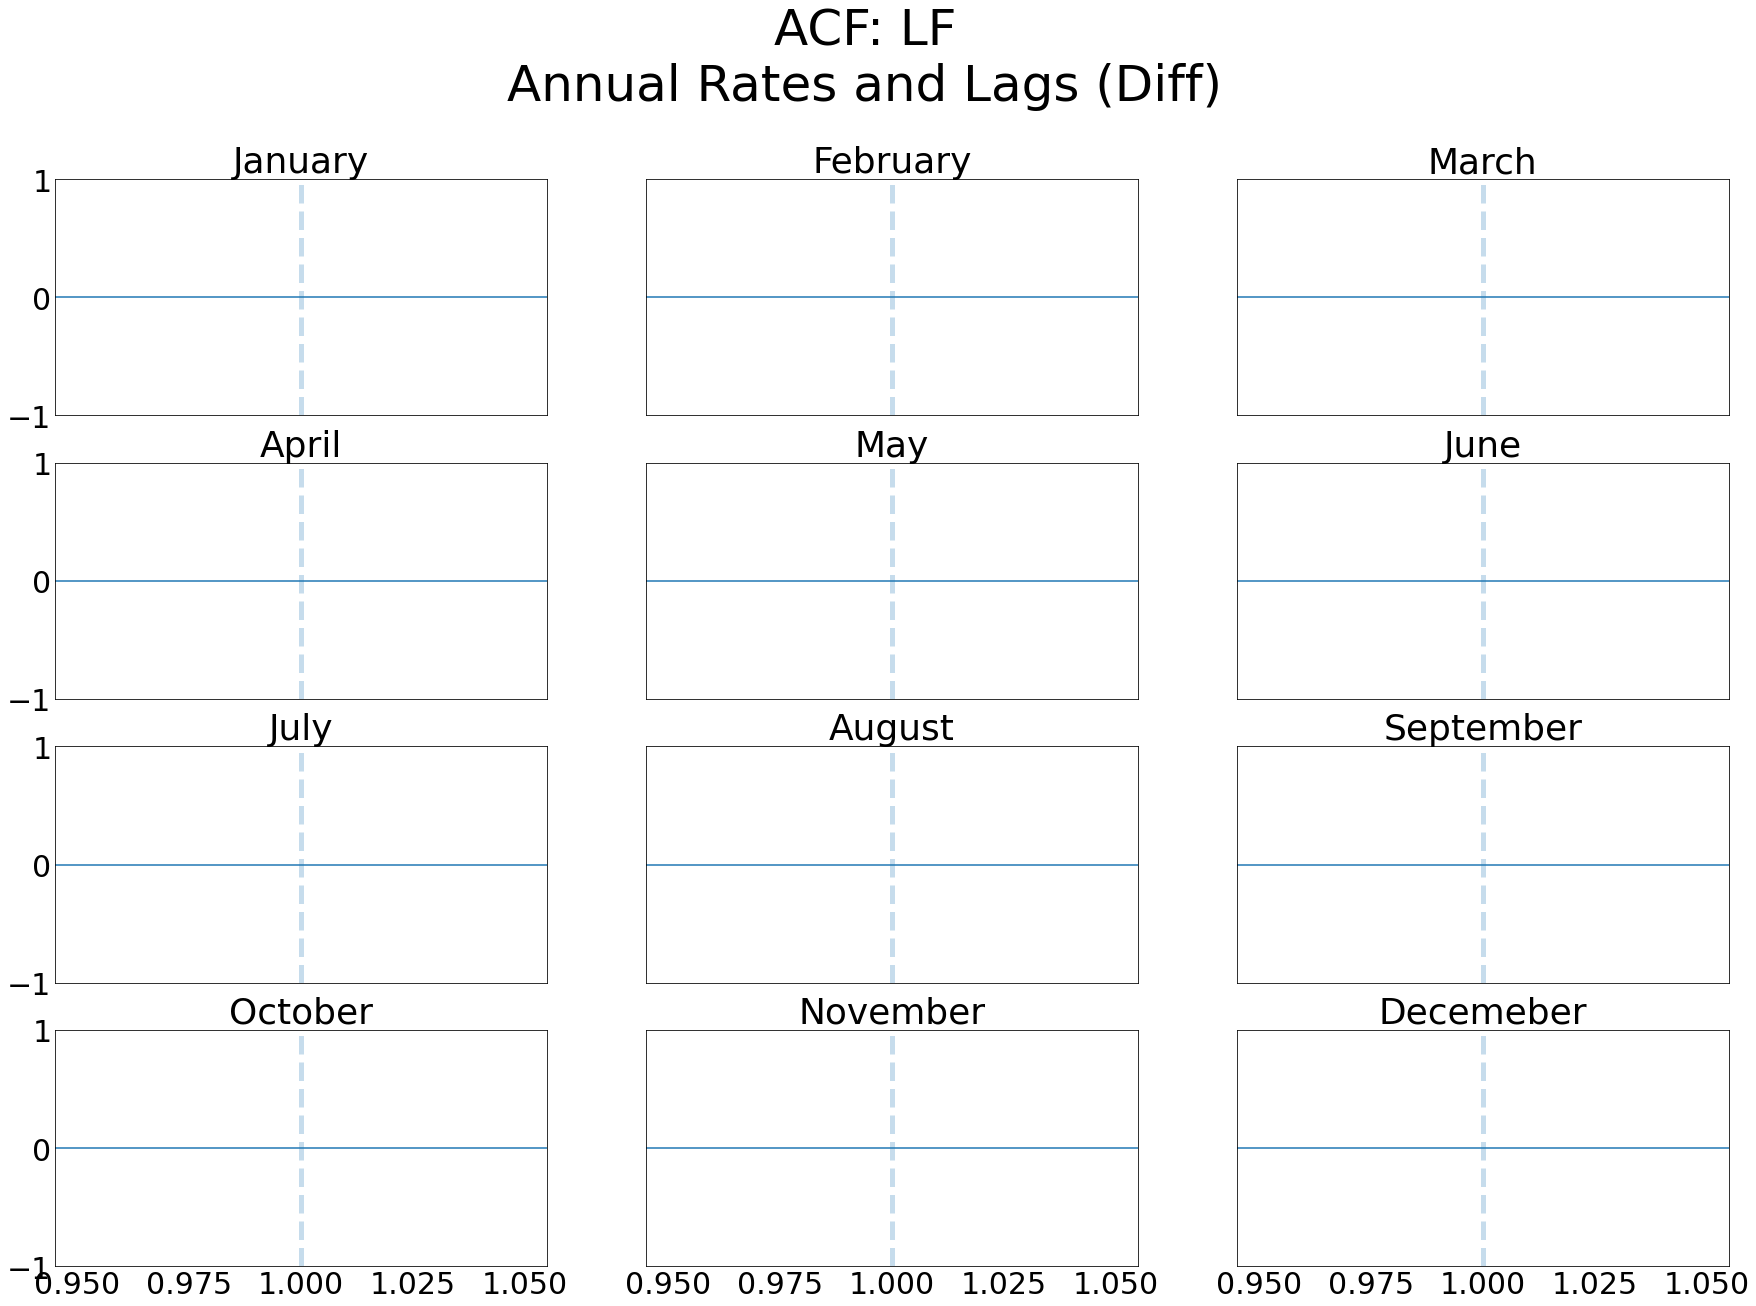

In [12]:
width, length = 3,4
months = {"January":1,
          "February":2,
          "March":3, 
          "April":4, 
          "May":5, 
          "June":6, 
          "July":7, 
          "August":8,
          "September":9, 
          "October":10, 
          "November":11,
          "Decemeber":0}


for diff in diffs:
    for key, val in test_data_dct[diff].items(): #.loc["2010":"2020-02-29"].items():
        fig,ax = plt.subplots(length, width,figsize = (30,20))
        i, j = 0, 0
        for month_name, index_num in months.items():
            a = ax[i][j]
            a.axvline(1, ls = "--", linewidth = 5, color = "C0", alpha = .25)
            plot_acf(val.iloc[index_num::12], title = key, ax = a, lags = 5, bartlett_confint = False)
            a.set_title(month_name)
            a.tick_params(axis=u'both', which=u'both',length=0)

            if j > 0:
                a.set_yticklabels([])
            if i < length - 1:
                a.set_xticklabels([])
                
            j+=1
            
            if j == width:
                j = 0
                i += 1
        fig.suptitle("ACF: " + key + "\nAnnual Rates and Lags (" + diff + ")", fontsize = 50, y = 1)
        fig.savefig("Figures/ACF" + key.replace("$","").replace("\\","") + "Annual" + diff + ".png")


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

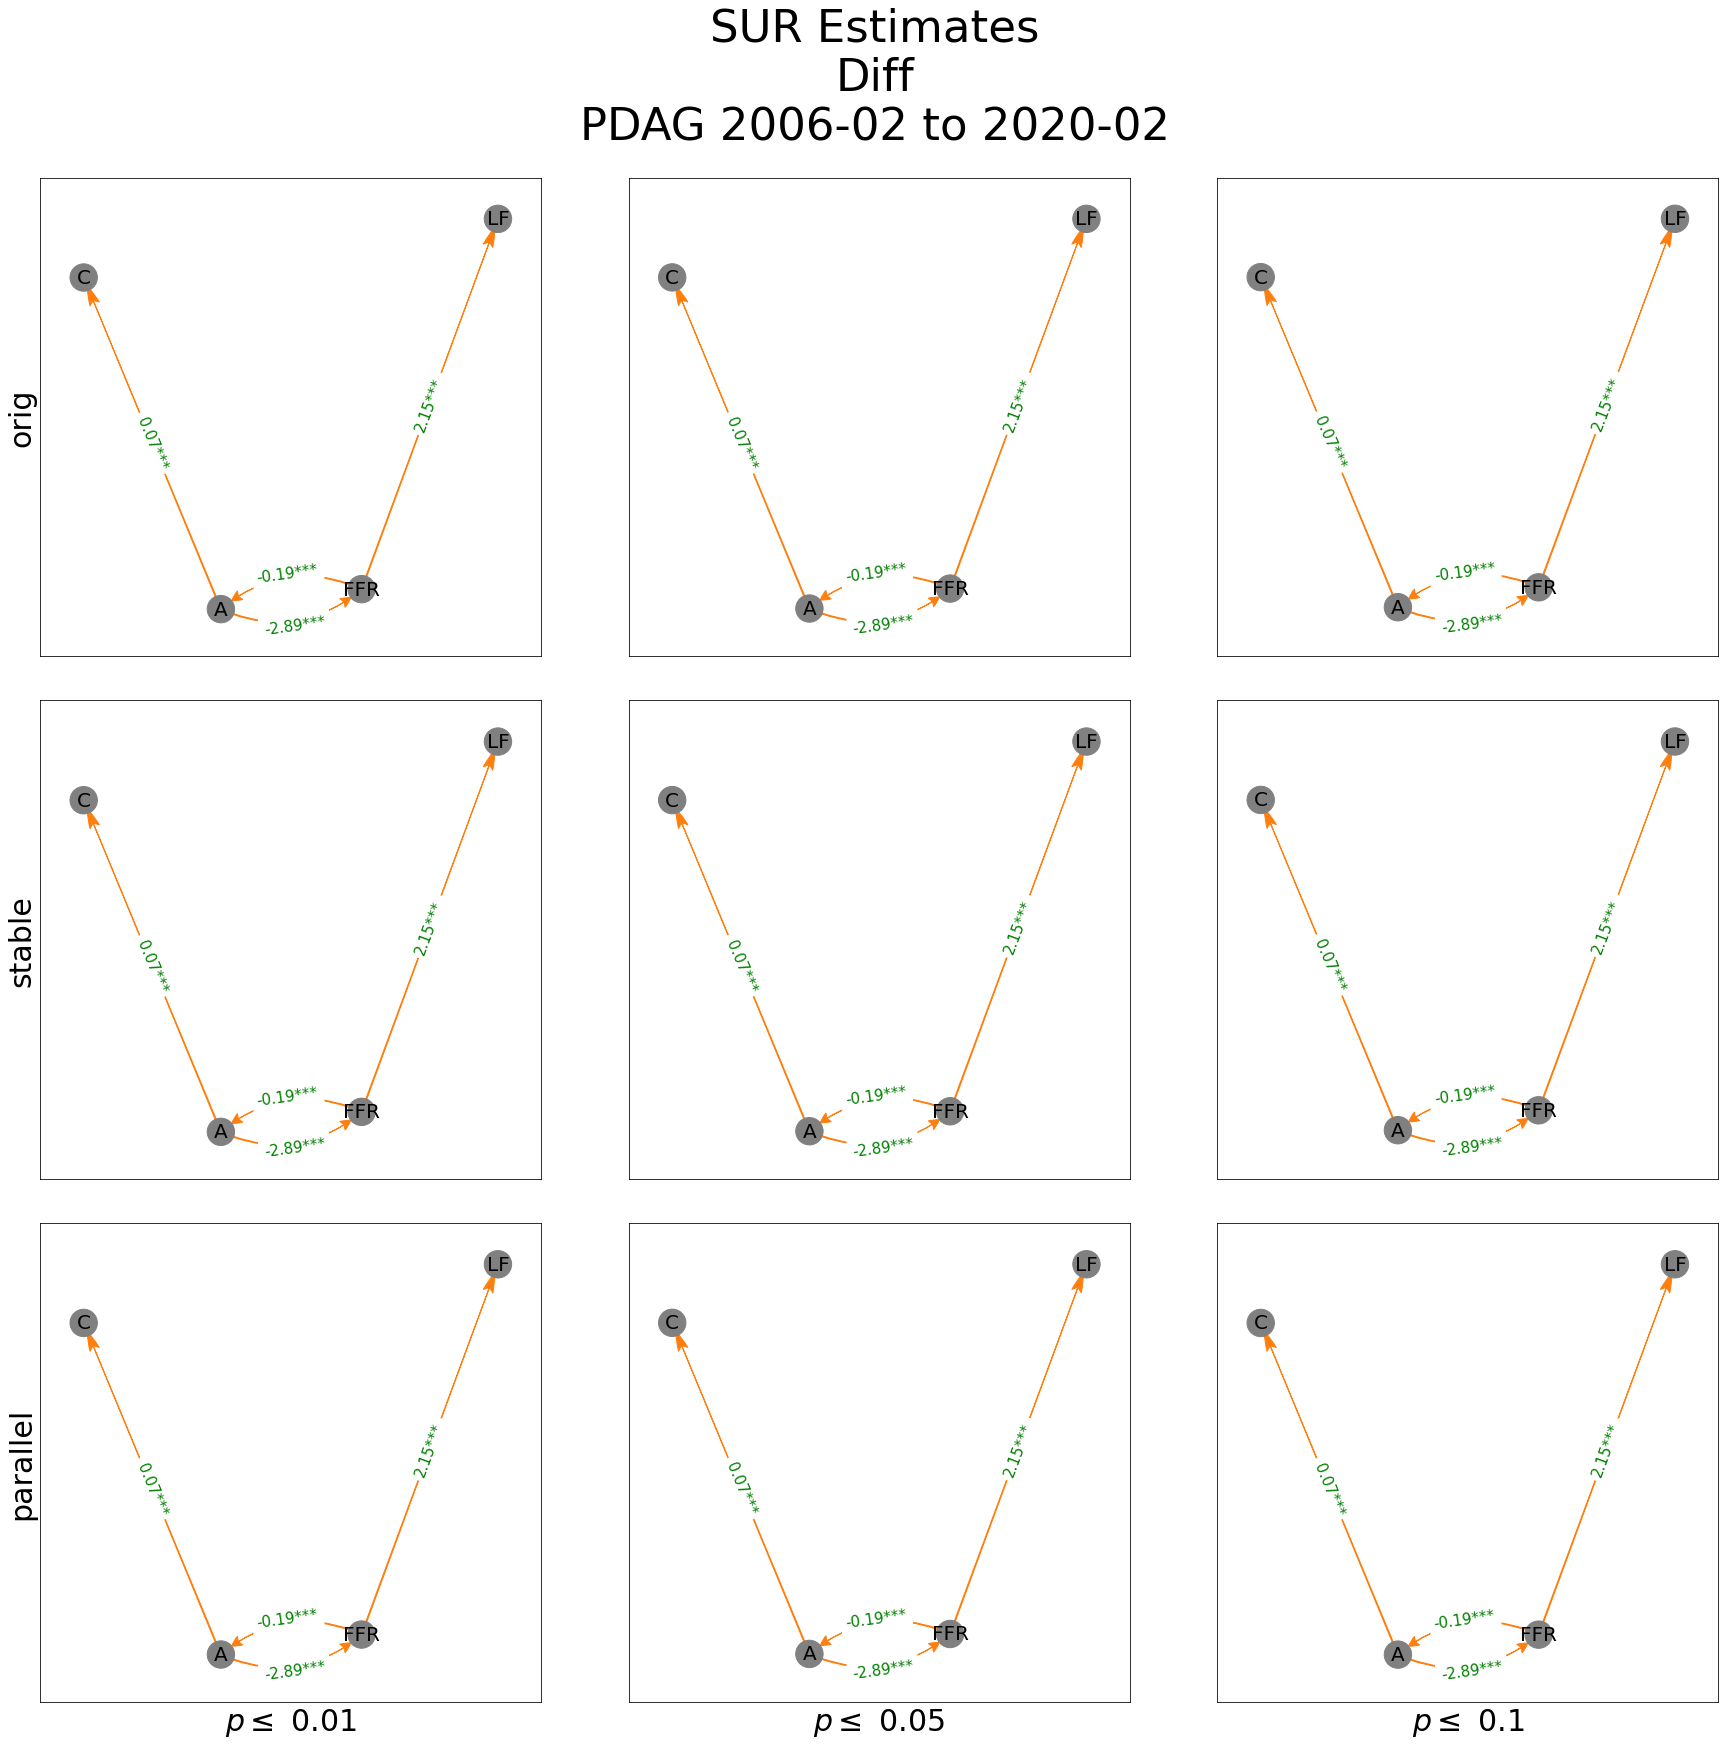

In [13]:
from datlib.DAG import *
from collections import OrderedDict
from linearmodels.system import SUR
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from linearmodels.system import SUR


# plt.rcParams.update({"font.size":20})
# pd.to_datetime(data['Date'])
# data.set_index("Date")
# diff = "Diff"

sig_vals = [.05, .01, 0.001]


def add_lags(data, lags=12 / year):
    for key in data:
        for i in range(1, lags + 1):
            new_key = key +" Lag" * i
            data[new_key] = var_data[key].shift(year * i)
    return data



                
# Following KPSS, use once differenced data
diffs = ["Diff"]#, "2Diff"]
reg_dict = {}
lags = int(round(12 / year,0))
width = length = 25
for diff in diffs:

    ## Use return_type = "pdag" to allow for endogeneity
    ##  "dag" disallows this sort ambiguity
    reg_dict[diff] = {}
    # only test the aggregated data, since the hypothesis is that:
        # 1) currency and total assets are indicate relative provision of liquidity
        # 2) loss function variables are targeted together

    plot_vars = ["FFR", "C", "A", "LF"]#, "B"]

    sigs = [0.01, 0.05, 0.1]
    variants = ["orig", "stable", "parallel"]
    ci_test = "pearsonr"

    

    # for plot_vars in plot_vars_dct:
    i = ""
    reg_dict[diff][i] = {}
    
    df =  rename_vars(data[diff][test_vars], rename_dct)   
    var_data = df[plot_vars]
    var_data.dropna(inplace=True)
#     for key in ["B", "C"]:
#         var_data[key + "Lag"] = var_data[key].shift(year) 
    # slice dfs by date range, house in dfs {}
    dfs = {}
    
    for start,end in start_end_list:
        dfs[start +" to " + end] =  var_data.loc[start:end].copy() 

    # use dates (key) to track dates for which hypotheses are tested
    for dates, select_df in dfs.items():
        select_df.dropna(inplace = True)
        
        for return_type in ["pdag"]:
            edges = {}
            dag_df = {}
#             fig, ax = plt.subplots(3,3,figsize = (width,length))
#             fig.suptitle("DAG Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " + dates,
#                         fontsize = 45)

            fig_sur, ax_sur = plt.subplots(3,len(sigs),figsize = (width,length))
            fig_sur.suptitle(
                "SUR Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " +\
                str(list(select_df.dropna().index)[0])[:7] +" to " +  dates[-10:-3],
                        fontsize = 45)
#             fig_var, ax_var = plt.subplots(3,3,figsize = (20,20))
#             fig_var.suptitle("VAR Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " + dates,
#                         fontsize = 45)
            
            for x in range(len(sigs)):
                sig = sigs[x]
                edges[sig] = {}
                dag_df[sig] = {}
                for y in range(len(variants)):
                    variant = variants[y]
                    a = ax[x][y]

                    constant = False if  "Diff" in diff else True
                    keys = select_df.keys()#[k for k in select_df if "Lag" not in k]
                    dag_df[sig][variant] = select_df[keys].dropna()

                    # construct dag, save directed edges
                    edges[sig][variant] = DAG(dag_df[sig][variant], variant, ci_test, sig, return_type)
                    # construct graphs with PC labels
                    graph_DAG(edges[sig][variant], 
                              dag_df[sig][variant], 
                              title = "",
                              fig = fig,
                              ax = a)
                    if x == 0:
                        a.set_ylabel(variant, fontsize = 30)
                    if y == len(variants) - 1:
                        a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)
                    a = ax_sur[y][x]
#                     identify sink nodes in directed dag edges, use info to detect structure of regressions
#                      additional graphs with marginal effects from SUR and VAR are constructed
                    sink_source = identify_sink_nodes(edges[sig][variant])
                    filename = i + " " + diff + "DAGOLS " + dates + " " + variant + str(sig) 
                    DAG_OLS(dag_df[sig][variant], 
                            sink_source, 
                            filename, 
                            a, 
                            diff, 
                            dates,
                            constant = constant, 
                            return_type = return_type)    
                    if x == 0:
                        a.set_ylabel(variant, fontsize = 30)
                    if y == len(variants) - 1:
                        a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)

#             reg_data = select_df.copy()
#             endog_keys= list(select_df.keys())
#             # reg_data = data["Log"][plot_vars].diff().loc[:"2019"]
# #             reg_data["Constant"] = 1
#             # reg_data = .copy()
#             lag_order = year
#             exog_keys = []    
#             for key in endog_keys:
#                 for j in range(1,2):# lag_order + 1):
#                     lag = j * year
#                     lag_key = key + " Lag" + str(j)
#                     reg_data[lag_key] = reg_data[key].shift(lag)
#                     exog_keys.append(lag_key)
# #             exog_keys.append("Constant")
#             endog = reg_data[endog_keys]
#             exog = reg_data[exog_keys]
#             model = SUR.multivariate_ls(endog,exog)  
#             mv_results = model.fit(cov_type="kernel", kernel="parzen")#cov_type='HAC')#cov_kwds={'maxlags':4})
#             print(mv_results)
            
#                     a = ax_var[y][x]
# 
#                     filename = i + " " + diff + "DAGVAR " + dates 
#                     DAG_VAR(add_lags(dag_df[sig][variant],lags).dropna(), sink_source, filename, a, diff, dates, sig_vals,constant = constant, return_type = return_type)
#                     if x == 0:
#                         a.set_ylabel(variant, fontsize = 30)
#                     if y == len(variants) - 1:
#                         a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)

In [14]:
select_df.keys()

Index(['FFR', 'C', 'A', 'LF'], dtype='object')

In [15]:

                
# # Following KPSS, use once differenced data
# diffs = ["Diff"]#, "2Diff"]
# reg_dict = {}
# lags = int(round(12 / year,0))
# width = length = 25
# for diff in diffs:

#     ## Use return_type = "pdag" to allow for endogeneity
#     ##  "dag" disallows this sort ambiguity
#     reg_dict[diff] = {}
#     # only test the aggregated data, since the hypothesis is that:
#         # 1) currency and total assets are indicate relative provision of liquidity
#         # 2) loss function variables are targeted together

# #     plot_vars = ["FFR", "C", "B", "LF"]

#     plot_vars = ["FFR", "C", "A", "LF"]
#     sig = sigs = [0.01, 0.05, 0.1]
#     variants = ["orig", "stable", "parallel"]
#     ci_test = "pearsonr"


#     # for plot_vars in plot_vars_dct:
#     i = ""
#     reg_dict[diff][i] = {}
    
#     df =  rename_vars(data[diff][test_vars], rename_dct)   
#     var_data = df[plot_vars]
#     var_data.dropna(inplace=True)

#     # slice dfs by date range, house in dfs {}
#     dfs = {}
# #     for start,end in start_end_list:
# #         dfs[start +" to " + end] =  var_data.loc[start:end].copy() 
#     dfs["2006-02 to 2020-02"] =  var_data.loc["2006-02":"2020-02"].copy() 
#     # use dates (key) to track dates for which hypotheses are tested
#     for dates, select_df in dfs.items():
#         select_df.dropna(inplace = True)
#         for return_type in ["pdag"]:
#             edges = {}
#             dag_df = {}
# #             fig, ax = plt.subplots(3,3,figsize = (width,length))
# #             fig.suptitle("DAG Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " + dates,
# #                         fontsize = 45)

#             fig_sur, ax_sur = plt.subplots(3,3,figsize = (width,length))
#             fig_sur.suptitle(
#                 "SUR Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " +\
#                 str(list(select_df.dropna().index)[0])[:7] +" to " +  dates[-10:-3],
#                         fontsize = 45)
# #             fig_var, ax_var = plt.subplots(3,3,figsize = (20,20))
# #             fig_var.suptitle("VAR Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " + dates,
# #                         fontsize = 45)
            
#             for x in range(len(sigs)):
#                 sig = sigs[x]
#                 edges[sig] = {}
#                 dag_df[sig] = {}
#                 for y in range(len(variants)):
#                     variant = variants[y]
#                     a = ax[y][x]

#                     constant = False if  "Diff" in diff else True
#                     keys = select_df.keys()#[k for k in select_df if "Lag" not in k]
#                     dag_df[sig][variant] = select_df[keys].dropna()
#                     # construct dag, save directed edges
#                     edges[sig][variant] = DAG(dag_df[sig][variant], variant, ci_test, sig, return_type)
#                     # construct graphs with PC labels
#                     graph_DAG(edges[sig][variant], 
#                               dag_df[sig][variant], 
#                               title = "",
#                               fig = fig,
#                               ax = a)
#                     if x == 0:
#                         a.set_ylabel(variant, fontsize = 30)
#                     if y == len(variants) - 1:
#                         a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)
#                     a = ax_sur[y][x]
# #                     identify sink nodes in directed dag edges, use info to detect structure of regressions
# #                      additional graphs with marginal effects from SUR and VAR are constructed
#                     sink_source = identify_sink_nodes(edges[sig][variant])
#                     filename = i + " " + diff + "DAGOLS " + dates + " " + variant + str(sig) 
#                     DAG_OLS(dag_df[sig][variant], 
#                             sink_source, 
#                             filename, 
#                             a, 
#                             diff, 
#                             dates,
#                             constant = constant, 
#                             return_type = return_type)    
#                     if x == 0:
#                         a.set_ylabel(variant, fontsize = 30)
#                     if y == len(variants) - 1:
#                         a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)

# #             reg_data = select_df.copy()
# #             endog_keys= list(select_df.keys())
# #             # reg_data = data["Log"][plot_vars].diff().loc[:"2019"]
# # #             reg_data["Constant"] = 1
# #             # reg_data = .copy()
# #             lag_order = year
# #             exog_keys = []    
# #             for key in endog_keys:
# #                 for j in range(1,2):# lag_order + 1):
# #                     lag = j * year
# #                     lag_key = key + " Lag" + str(j)
# #                     reg_data[lag_key] = reg_data[key].shift(lag)
# #                     exog_keys.append(lag_key)
# # #             exog_keys.append("Constant")
# #             endog = reg_data[endog_keys]
# #             exog = reg_data[exog_keys]
# #             model = SUR.multivariate_ls(endog,exog)  
# #             mv_results = model.fit(cov_type="kernel", kernel="parzen")#cov_type='HAC')#cov_kwds={'maxlags':4})
# #             print(mv_results)
            
# #                     a = ax_var[y][x]
# # 
# #                     filename = i + " " + diff + "DAGVAR " + dates 
# #                     DAG_VAR(add_lags(dag_df[sig][variant],lags).dropna(), sink_source, filename, a, diff, dates, sig_vals,constant = constant, return_type = return_type)
# #                     if x == 0:
# #                         a.set_ylabel(variant, fontsize = 30)
# #                     if y == len(variants) - 1:
# #                         a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)